# ABC TelCo: Customer Churn Prediction Modeling Notebook

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
import time
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score, accuracy_score, make_scorer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import shap
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Suppress warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.3f}'.format)

# Set plotting style
plt.style.use('ggplot')
sns.set(style="whitegrid")

C:\Users\oldys\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 0. Merging the anger scores

In [29]:
# Read the main customer data (already done in Cell 6)
customer_data = pd.read_csv(r'customers_complaints_merdged.csv')

# Read the anger scores
anger_scores = pd.read_csv(r'complaints_angry_scores.csv')

# Rename customerID in anger_scores to match CustomerID in customer_data
anger_scores = anger_scores.rename(columns={'customerID': 'CustomerId'})

# Calculate mean anger score per customer
mean_anger_scores = anger_scores.groupby('CustomerId')['anger_score'].mean().reset_index()

# Merge customer data with mean anger scores on CustomerId
data = pd.merge(customer_data, mean_anger_scores, on='CustomerId', how='left')

# Fill NaN values with 0 for anger scores (for customers without complaints)
data['anger_score'] = data['anger_score'].fillna(0)

# Display first few rows of merged dataset
print("Shape of merged dataset:", data.shape)
print("\nSample of customers with complaints:")
display(data[data.HasComplaint == 1].head())

# Save the merged dataset to a CSV file
data.to_csv('customers_merged_with_anger_scores.csv', index=False)
print("\nDataset saved successfully!")

Shape of merged dataset: (7043, 47)

Sample of customers with complaints:


,CustomerId,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,ContractLengthMonths,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,ChangedPlan,ChangedPlanPositive,ChangedPlanNegative,InternetServicesDensity,Complaint,HasComplaint,anger_score
31,4929-XIHVW,Male,1,Yes,0,2,1,1,95.500,181.650,0,1,True,False,False,False,True,False,True,False,False,True,False,False,False,False,True,True,False,False,False,False,True,False,False,True,False,True,False,False,1,1,0,0.500,"The streaming services I signed up for, includ...",1,5.000
36,6047-YHPVI,Male,0,No,0,5,1,1,69.700,316.900,1,1,True,False,False,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,False,True,False,1,1,0,0.000,My internet service has been extremely unrelia...,1,6.000
45,3714-NTNFO,Female,0,No,0,49,1,1,84.500,3906.700,0,1,False,False,True,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,False,True,False,False,True,False,1,1,0,0.167,The streaming movies service often lags or buf...,1,5.750
62,0526-SXDJP,Male,0,Yes,0,72,0,0,42.100,2962.000,0,24,False,True,False,True,False,False,False,False,True,False,False,True,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,False,1,1,0,0.500,"I don’t use streaming services, yet my monthly...",1,5.250
80,5919-TMRGD,Female,0,No,1,1,1,1,79.350,79.350,1,1,True,False,False,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,False,False,True,True,False,False,False,False,True,False,0,0,0,0.167,The streaming TV service I signed up for has b...,1,5.000



Dataset saved successfully!


# 1. Data Loading and Overview

In [30]:
import os

print("Current working directory:", os.getcwd())

Current working directory: d:\Desktop\2_HackLab\churn_bcgx\modelling


In [36]:
# Load the data
data = pd.read_csv(r'customers_merged_with_anger_scores.csv')

In [37]:
# Display basic information
print(f"Dataset shape: {data.shape}")
print(f"Number of features: {data.shape[1]-1}") # Excluding the target variable
print(f"Number of samples: {data.shape[0]}")

Dataset shape: (7043, 47)
Number of features: 46
Number of samples: 7043


In [38]:
# Display first few rows
print("\nFirst few rows:")
data.head()


First few rows:


,CustomerId,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,ContractLengthMonths,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,ChangedPlan,ChangedPlanPositive,ChangedPlanNegative,InternetServicesDensity,Complaint,HasComplaint,anger_score
0,7590-VHVEG,Female,0,Yes,0,1,0,1,29.850,29.850,0,1,False,True,False,True,False,False,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,False,False,True,False,0,0,0,0.167,NaN,0,0.000
1,5575-GNVDE,Male,0,No,0,34,1,0,56.950,1889.500,0,12,True,False,False,True,False,False,False,False,True,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,False,False,False,True,1,1,0,0.333,NaN,0,0.000
2,3668-QPYBK,Male,0,No,0,2,1,1,53.850,108.150,1,1,True,False,False,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,False,False,False,True,1,0,1,0.333,NaN,0,0.000
3,7795-CFOCW,Male,0,No,0,45,0,0,42.300,1840.750,0,12,False,True,False,True,False,False,False,False,True,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,True,False,False,False,1,1,0,0.500,NaN,0,0.000
4,9237-HQITU,Female,0,No,0,2,1,1,70.700,151.650,1,1,True,False,False,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,False,True,False,1,0,1,0.000,NaN,0,0.000


In [39]:
# Display basic statistics
print("\nBasic statistics:")
data.describe()


Basic statistics:


,SeniorCitizen,Dependents,Tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,ContractLengthMonths,ChangedPlan,ChangedPlanPositive,ChangedPlanNegative,InternetServicesDensity,HasComplaint,anger_score
count,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000
mean,0.162,0.300,32.371,0.903,0.592,64.762,2279.799,0.265,8.836,0.913,0.456,0.456,0.340,0.100,0.571
std,0.369,0.458,24.559,0.296,0.491,30.090,2266.730,0.442,9.551,0.282,0.498,0.498,0.308,0.300,1.741
min,0.000,0.000,0.000,0.000,0.000,18.250,18.800,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.000,9.000,1.000,0.000,35.500,398.550,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000
50%,0.000,0.000,29.000,1.000,1.000,70.350,1394.550,0.000,1.000,1.000,0.000,0.000,0.333,0.000,0.000
75%,0.000,1.000,55.000,1.000,1.000,89.850,3786.600,1.000,12.000,1.000,1.000,1.000,0.500,0.000,0.000
max,1.000,1.000,72.000,1.000,1.000,118.750,8684.800,1.000,24.000,1.000,1.000,1.000,1.000,1.000,9.000


In [40]:
# Check for missing values
print("\nMissing values per column:")
missing_values = data.isnull().sum()
missing_values_percent = 100 * data.isnull().sum() / len(data)
missing_info = pd.concat([missing_values, missing_values_percent], axis=1)
missing_info.columns = ['Missing Values', 'Percentage']
missing_info[missing_info['Missing Values'] > 0].sort_values('Missing Values', ascending=False)


Missing values per column:


,Missing Values,Percentage
Complaint,6339,90.004


In [41]:
# Check data types
print("\nData types:")
data.dtypes


Data types:


CustomerId                                  object
Gender                                      object
SeniorCitizen                                int64
Partner                                     object
Dependents                                   int64
Tenure                                       int64
PhoneService                                 int64
PaperlessBilling                             int64
MonthlyCharges                             float64
TotalCharges                               float64
Churn                                        int64
ContractLengthMonths                         int64
MultipleLines_No                              bool
MultipleLines_No phone service                bool
MultipleLines_Yes                             bool
InternetService_DSL                           bool
InternetService_Fiber optic                   bool
InternetService_No                            bool
OnlineSecurity_No                             bool
OnlineSecurity_No internet serv

In [42]:
# Check for duplicates
print(f"\nDuplicated records: {data.duplicated().sum()}")


Duplicated records: 0


# 2. Exploratory Data Analysis

In [44]:
# Class distribution (target variable)
print("\nClass Distribution (Churn):")
churn_counts = data['Churn'].value_counts()
churn_percentage = 100 * data['Churn'].value_counts(normalize=True)
churn_dist = pd.DataFrame({'Count': churn_counts, 'Percentage': churn_percentage})
display(churn_dist)



Class Distribution (Churn):


,Count,Percentage
Churn,,
0,5174,73.463
1,1869,26.537


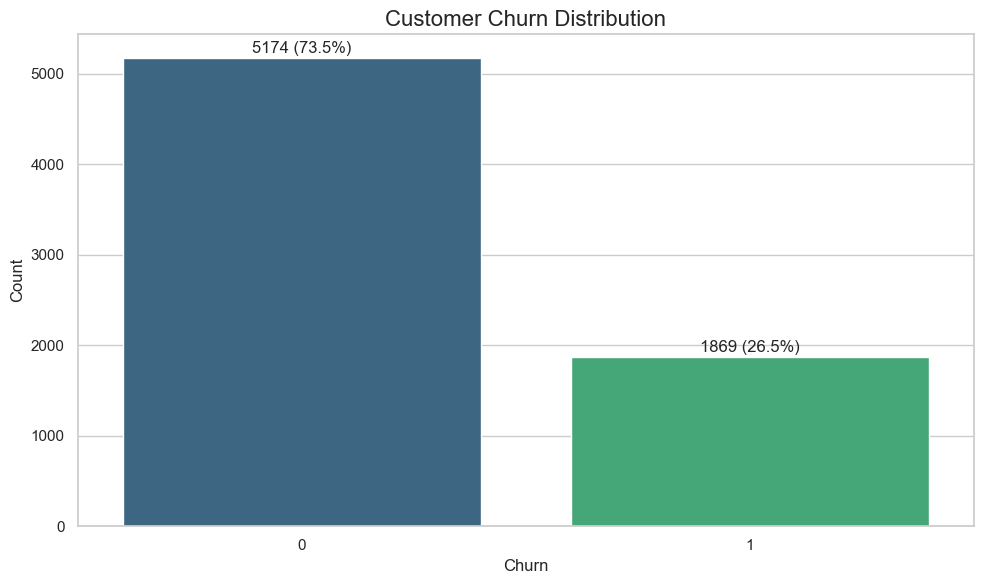

Churn Rate: 26.54%


In [45]:
# Visualize class distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Churn', data=data, palette='viridis')
plt.title('Customer Churn Distribution', fontsize=16)
plt.xlabel('Churn', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add count and percentage annotations
for i, (count, percentage) in enumerate(zip(churn_counts, churn_percentage)):
    ax.text(i, count + 50, f"{count} ({percentage:.1f}%)", ha='center', fontsize=12)

plt.tight_layout()
plt.show()

print(f"Churn Rate: {churn_percentage[1]:.2f}%")

In [46]:
# Function to create distribution plots for numerical features by churn
def plot_numeric_distributions(df, numeric_features, target='Churn'):
    n_features = len(numeric_features)
    n_cols = 2
    n_rows = math.ceil(n_features / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
    axes = axes.flatten()

    for i, feature in enumerate(numeric_features):
        if i < len(axes):
            sns.histplot(data=df, x=feature, hue=target, bins=30, kde=True, ax=axes[i])
            axes[i].set_title(f'Distribution of {feature} by Churn', fontsize=13)
            axes[i].set_xlabel(feature, fontsize=11)
            axes[i].set_ylabel('Count', fontsize=11)

    plt.tight_layout()
    plt.show()

# Function to create distribution plots for categorical features by churn
def plot_categorical_distributions(df, categorical_features, target='Churn'):
    n_features = len(categorical_features)
    n_cols = 2
    n_rows = math.ceil(n_features / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
    axes = axes.flatten()

    for i, feature in enumerate(categorical_features):
        if i < len(axes):
            # Calculate percentages for stacked bar chart
            temp_df = pd.crosstab(df[feature], df[target], normalize='index') * 100
            temp_df.plot(kind='bar', stacked=True, ax=axes[i], colormap='viridis')

            axes[i].set_title(f'Churn Percentage by {feature}', fontsize=13)
            axes[i].set_xlabel(feature, fontsize=11)
            axes[i].set_ylabel('Percentage (%)', fontsize=11)
            axes[i].legend(['No Churn', 'Churn'])

            # Add the count of samples above each bar
            counts = pd.crosstab(df[feature], df[target]).sum(axis=1)
            for j, p in enumerate(axes[i].patches):
                width, height = p.get_width(), p.get_height()
                x, y = p.get_xy()
                if j < len(counts):  # Add counts only for the first set of bars
                    axes[i].text(x+width/2,
                             y+height/2,
                             f'n={counts.iloc[j % len(counts)]}',
                             ha='center',
                             va='center',
                             fontsize=8,
                             color='white')

    plt.tight_layout()
    plt.show()

In [47]:
# Identify numeric and categorical features
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Drop Churn from numeric features as it's our target variable
if 'Churn' in numeric_features:
    numeric_features.remove('Churn')
# Drop CustomerID if present as it's an identifier
if 'CustomerId' in numeric_features:
    numeric_features.remove('CustomerId')


In [48]:
categorical_features = data.select_dtypes(include=['object', 'bool']).columns.tolist()
# Remove CustomerId and Complaint from categorical features
if 'CustomerId' in categorical_features:
    categorical_features.remove('CustomerId')
if 'Complaint' in categorical_features:
    categorical_features.remove('Complaint')

# Display numeric and categorical feature lists
print("\nNumeric Features:")
print(numeric_features)
print("\nCategorical Features:")
print(categorical_features)


Numeric Features:
['SeniorCitizen', 'Dependents', 'Tenure', 'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'ContractLengthMonths', 'ChangedPlan', 'ChangedPlanPositive', 'ChangedPlanNegative', 'InternetServicesDensity', 'HasComplaint', 'anger_score']

Categorical Features:
['Gender', 'Partner', 'MultipleLines_No', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'DeviceProtection_No', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes', 'StreamingMovies_No', 'StreamingMovies_No internet service', 'StreamingMovies_Yes', 'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_C


Distribution of Key Numeric Features by Churn:


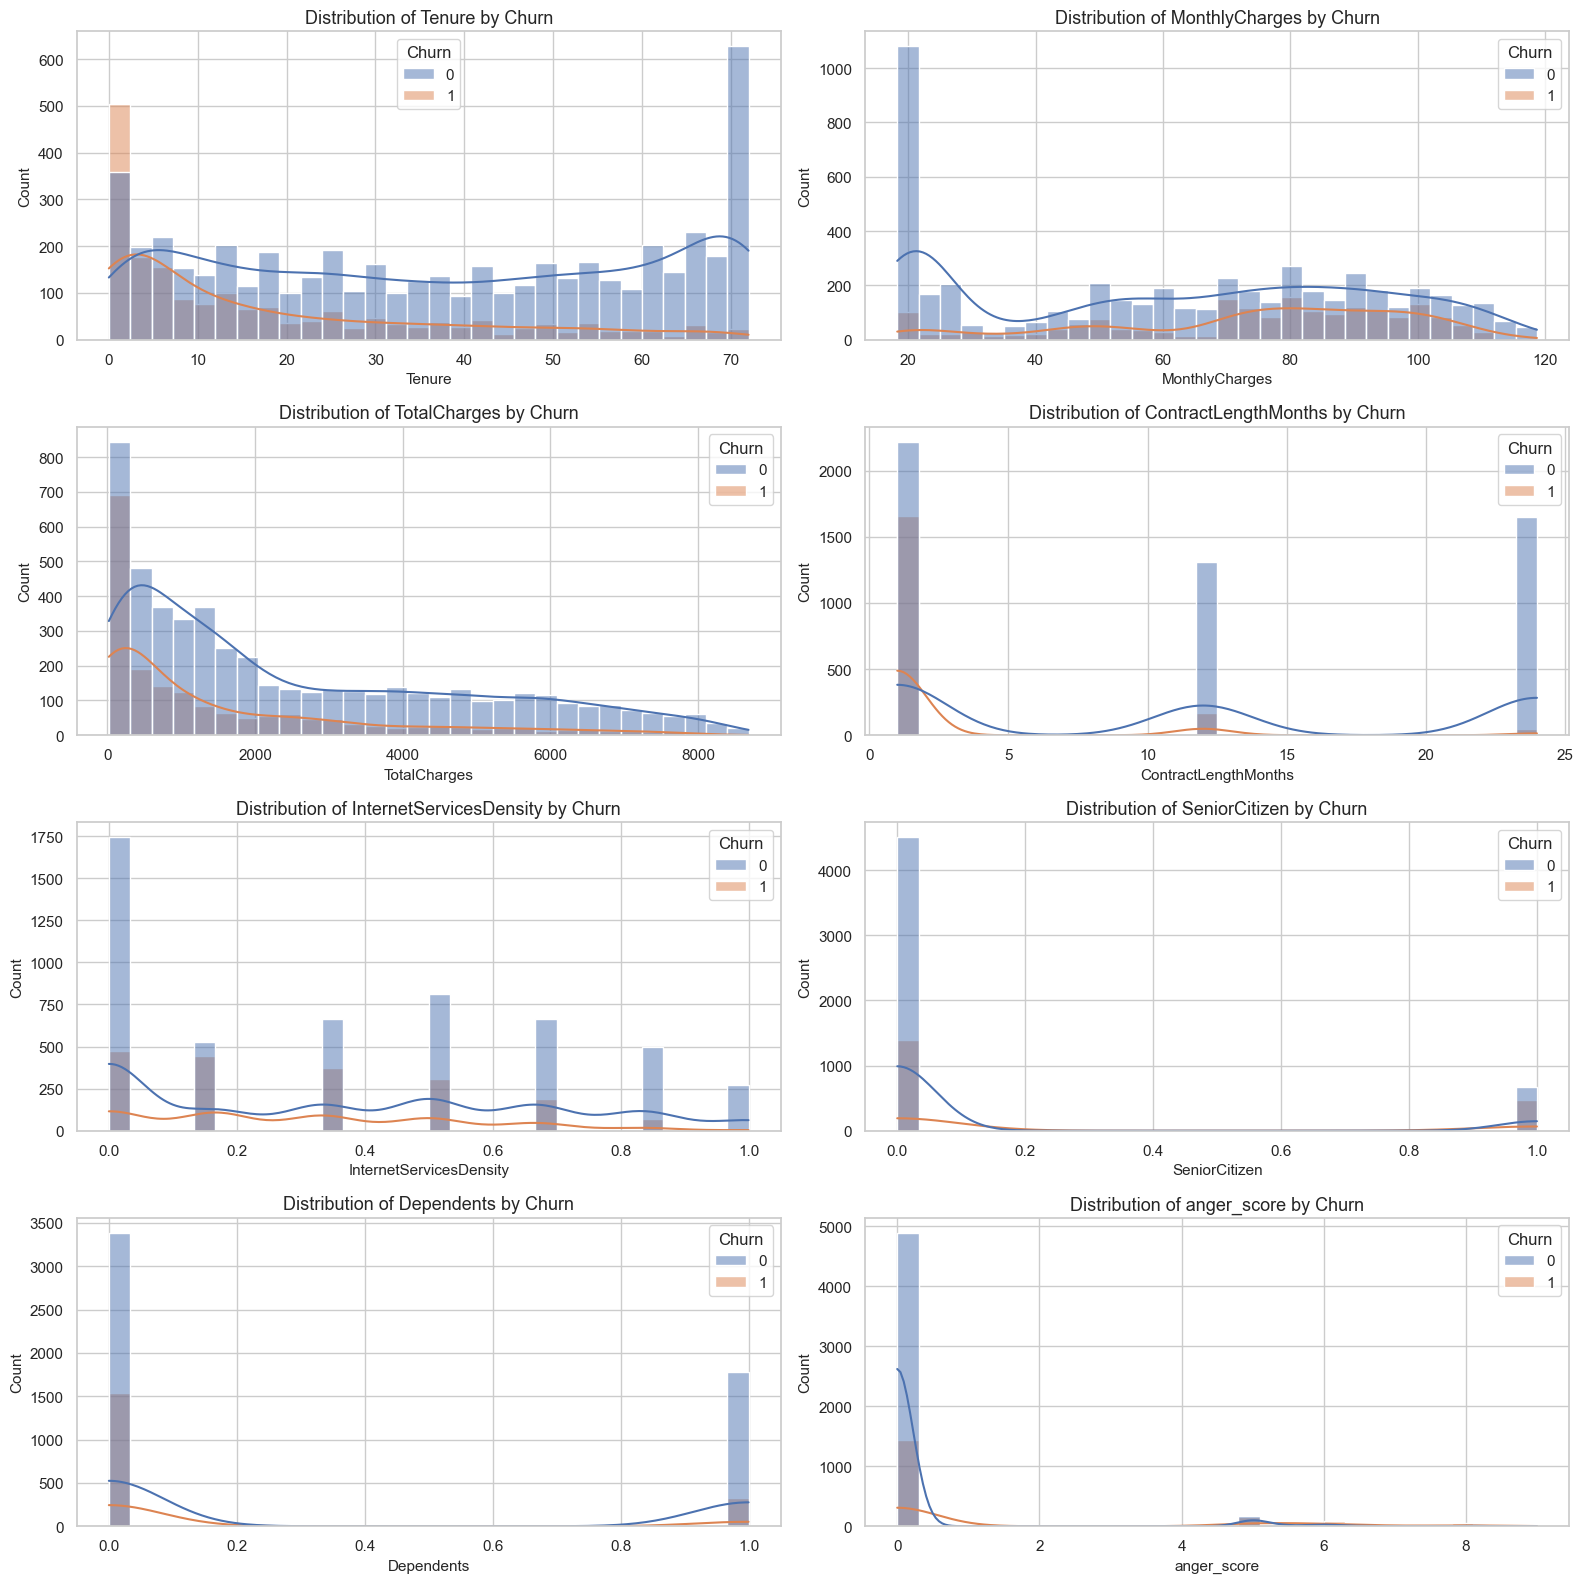

In [58]:
# Select key numeric features for visualization (too many to show all)
key_numeric_features = ['Tenure', 'MonthlyCharges', 'TotalCharges', 'ContractLengthMonths',
                         'InternetServicesDensity', 'SeniorCitizen', 'Dependents', 'anger_score']

# Plot distribution of key numeric features by churn
print("\nDistribution of Key Numeric Features by Churn:")
plot_numeric_distributions(data, key_numeric_features)


Distribution of Key Categorical Features by Churn:


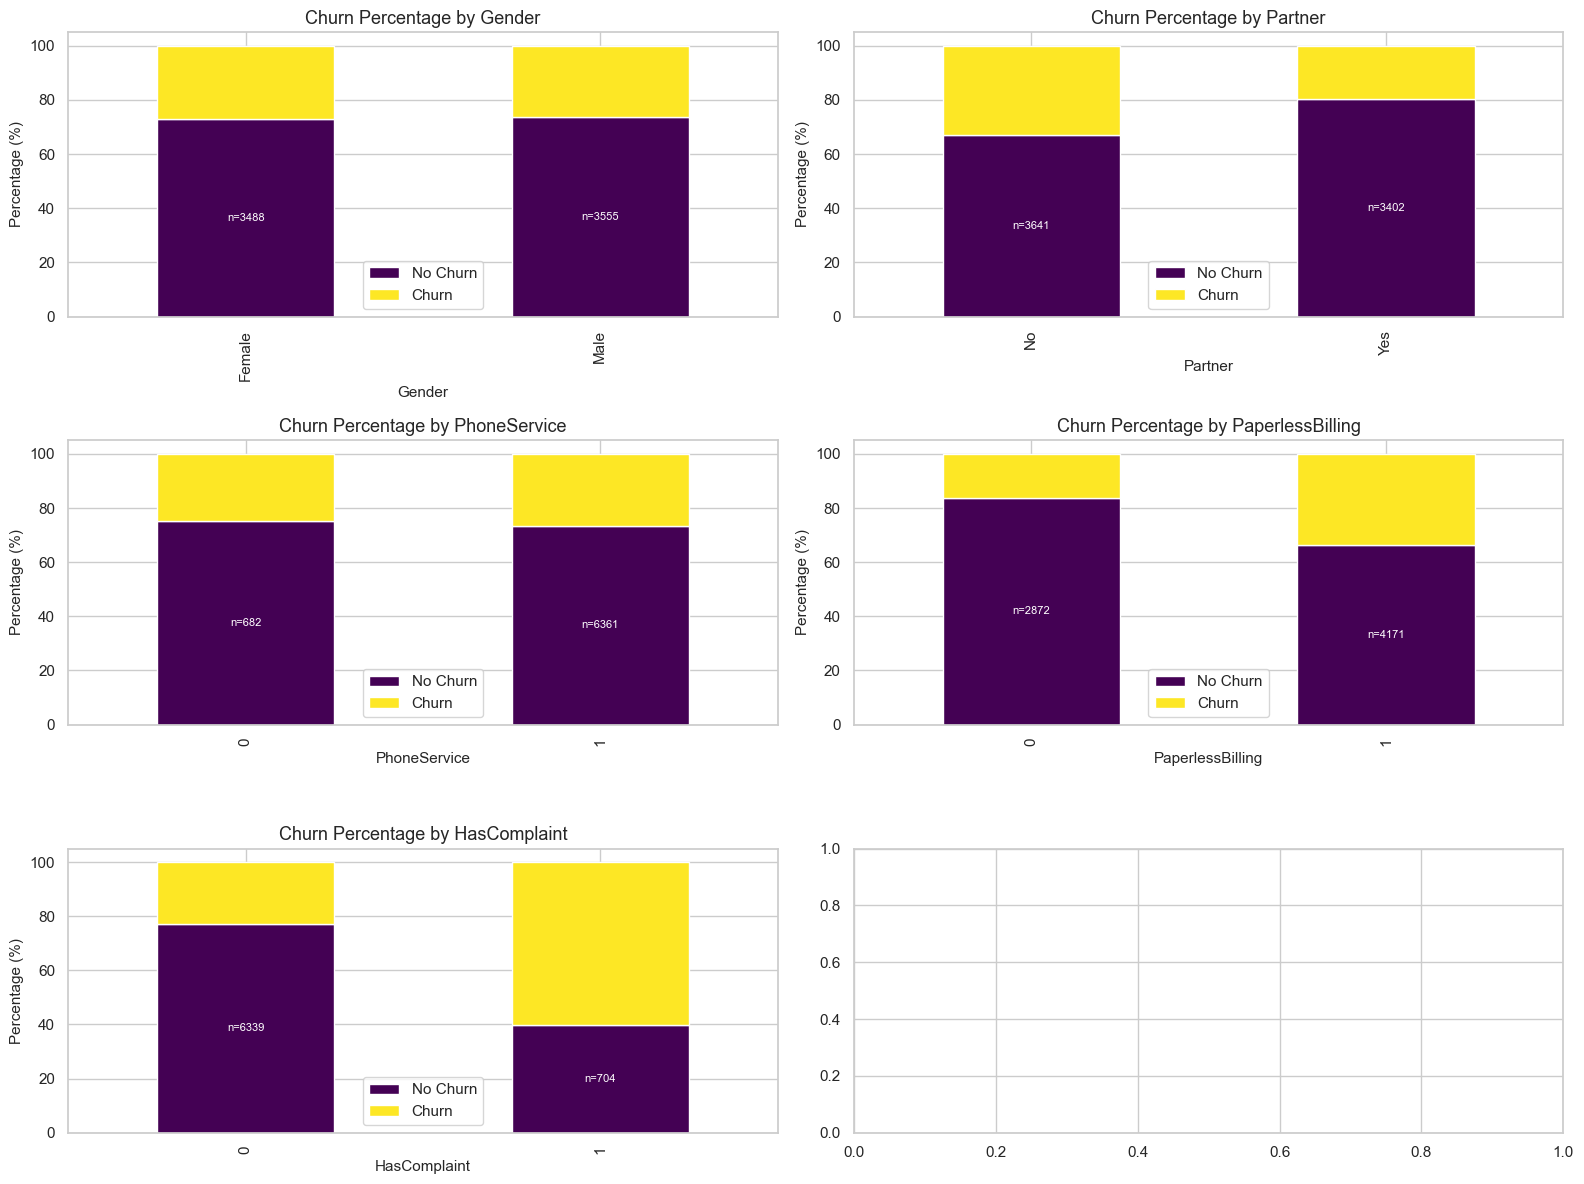

In [50]:
# Select key categorical features for visualization
key_categorical_features = ['Gender', 'Partner', 'PhoneService', 'PaperlessBilling', 'HasComplaint']

# Plot distribution of key categorical features by churn
print("\nDistribution of Key Categorical Features by Churn:")
plot_categorical_distributions(data, key_categorical_features)



Correlation Matrix for Numeric Features:


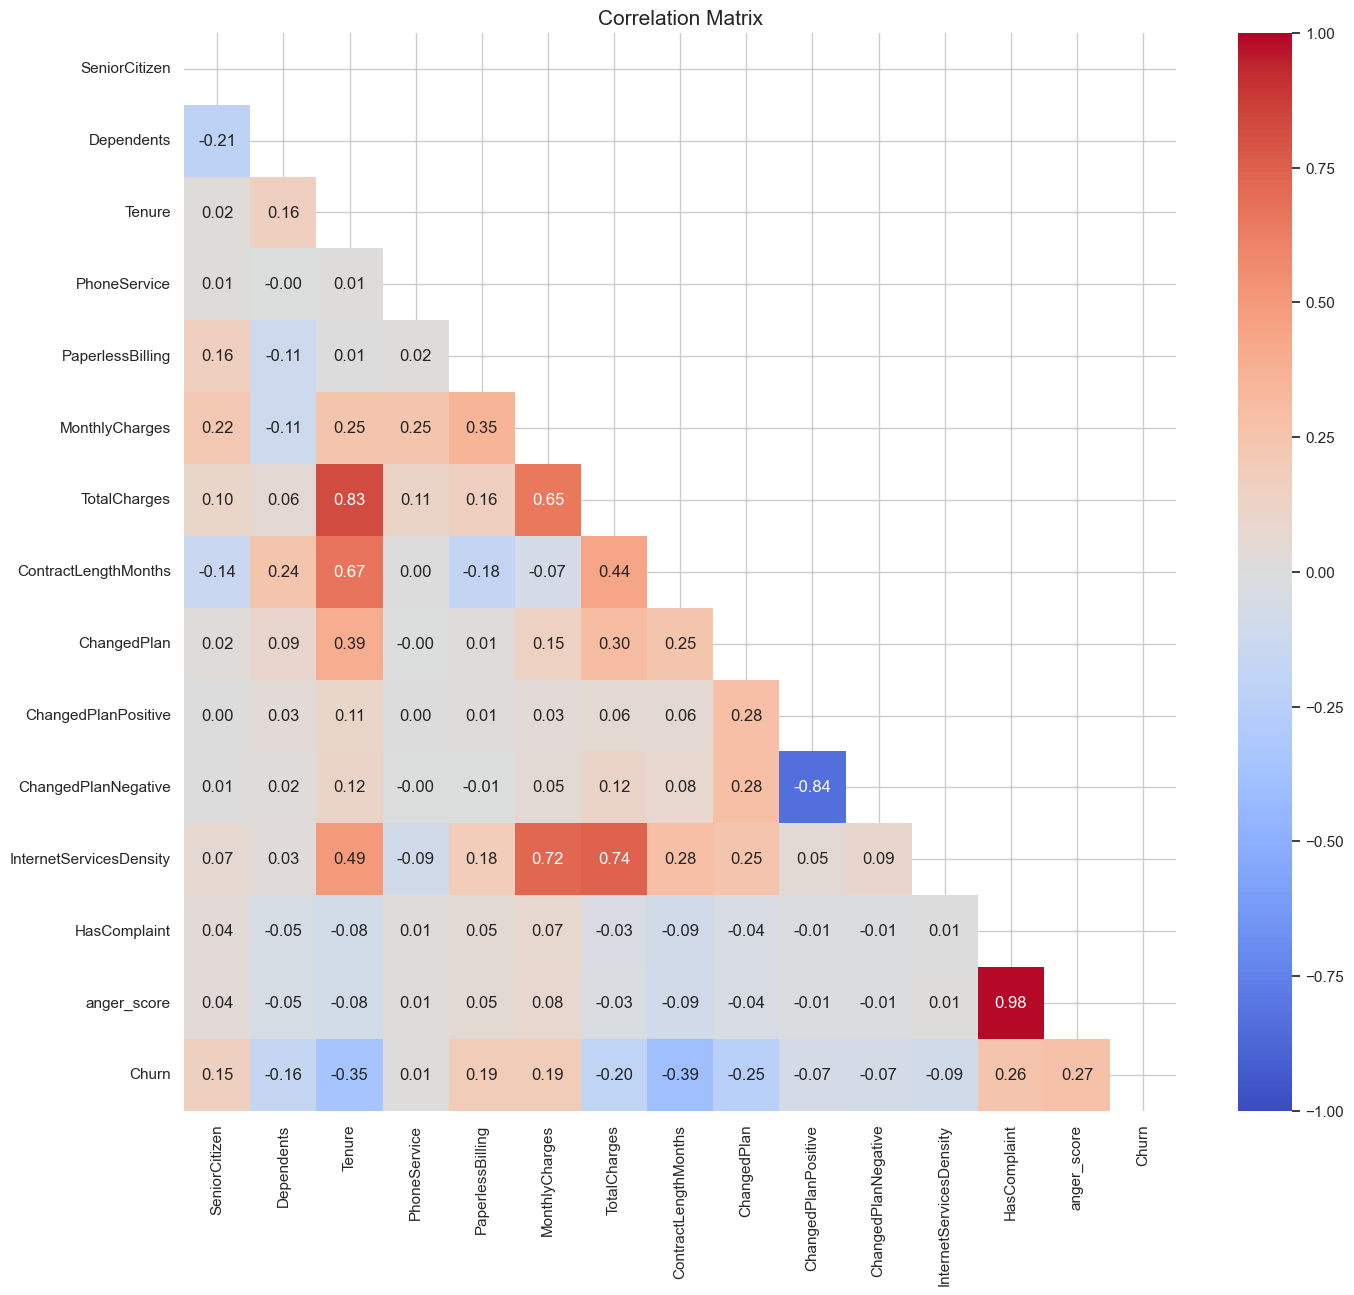

In [51]:
# Calculate and plot correlation matrix for numeric features
print("\nCorrelation Matrix for Numeric Features:")
corr = data[numeric_features + ['Churn']].corr()
plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix', fontsize=15)
plt.show()

In [52]:
# Identify top correlated features with churn
churn_corr = corr['Churn'].sort_values(ascending=False)
print("\nFeatures most correlated with Churn:")
display(churn_corr)


Features most correlated with Churn:


Churn                      1.000
anger_score                0.267
HasComplaint               0.255
MonthlyCharges             0.193
PaperlessBilling           0.192
SeniorCitizen              0.151
PhoneService               0.012
ChangedPlanPositive       -0.066
ChangedPlanNegative       -0.074
InternetServicesDensity   -0.088
Dependents                -0.164
TotalCharges              -0.198
ChangedPlan               -0.249
Tenure                    -0.352
ContractLengthMonths      -0.394
Name: Churn, dtype: float64

In [53]:
# Calculate Chi-squared statistic for categorical variables
def chi2_with_yates(df, categorical_var, target_var):
    contingency_table = pd.crosstab(df[categorical_var], df[target_var])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table, correction=True)
    return pd.Series({'Chi2': chi2, 'p-value': p, 'degrees_of_freedom': dof})

print("\nChi-squared tests for categorical variables with Churn:")
chi2_results = pd.DataFrame()
for cat_var in categorical_features:
    chi2_result = chi2_with_yates(data, cat_var, 'Churn')
    chi2_results[cat_var] = chi2_result

display(chi2_results.T.sort_values('Chi2', ascending=False))



Chi-squared tests for categorical variables with Churn:


,Chi2,p-value,degrees_of_freedom
OnlineSecurity_No,825.297,0.000,1.000
TechSupport_No,799.672,0.000,1.000
InternetService_Fiber optic,666.808,0.000,1.000
PaymentMethod_Electronic check,640.557,0.000,1.000
OnlineBackup_No,504.653,0.000,1.000
DeviceProtection_No,447.818,0.000,1.000
DeviceProtection_No internet service,364.520,0.000,1.000
StreamingMovies_No internet service,364.520,0.000,1.000
TechSupport_No internet service,364.520,0.000,1.000
InternetService_No,364.520,0.000,1.000



Pair plots for the top correlated features with Churn:


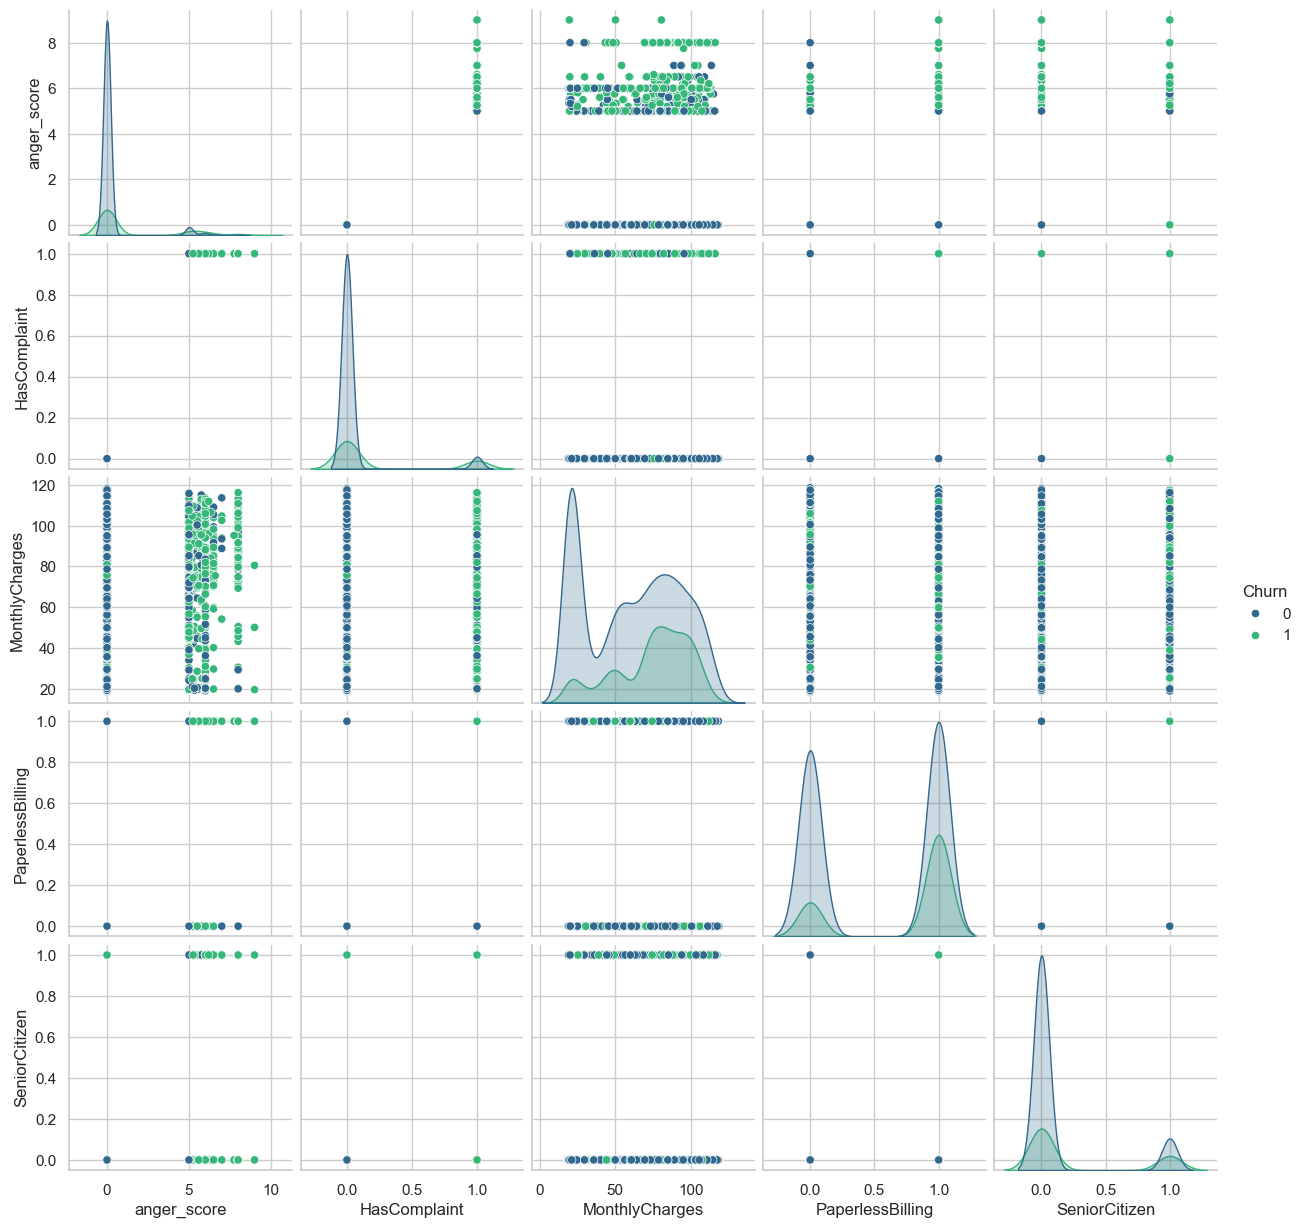

In [54]:
# Create pair plots for the top correlated numeric features
top_corr_features = churn_corr.index[:6].tolist()  # Top 5 correlated features + Churn
print("\nPair plots for the top correlated features with Churn:")
sns.pairplot(data[top_corr_features], hue='Churn', palette='viridis')
plt.show()

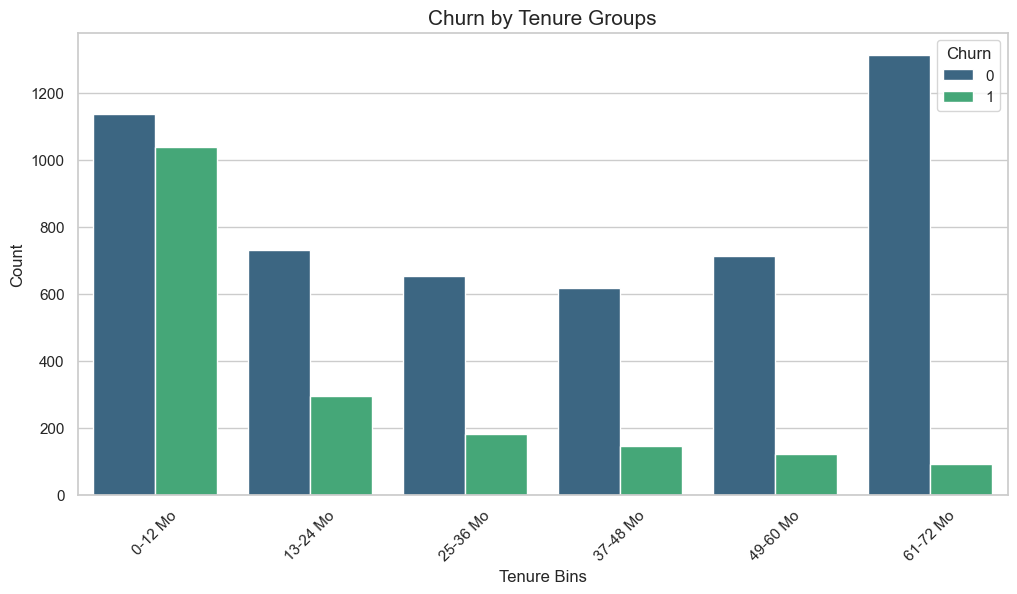

In [55]:
# Feature Engineering: Tenure Bins
data['TenureBin'] = pd.cut(data['Tenure'], bins=[0, 12, 24, 36, 48, 60, 72],
                          labels=['0-12 Mo', '13-24 Mo', '25-36 Mo', '37-48 Mo', '49-60 Mo', '61-72 Mo'])

plt.figure(figsize=(12, 6))
sns.countplot(x='TenureBin', hue='Churn', data=data, palette='viridis')
plt.title('Churn by Tenure Groups', fontsize=15)
plt.xlabel('Tenure Bins', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Churn')
plt.show()

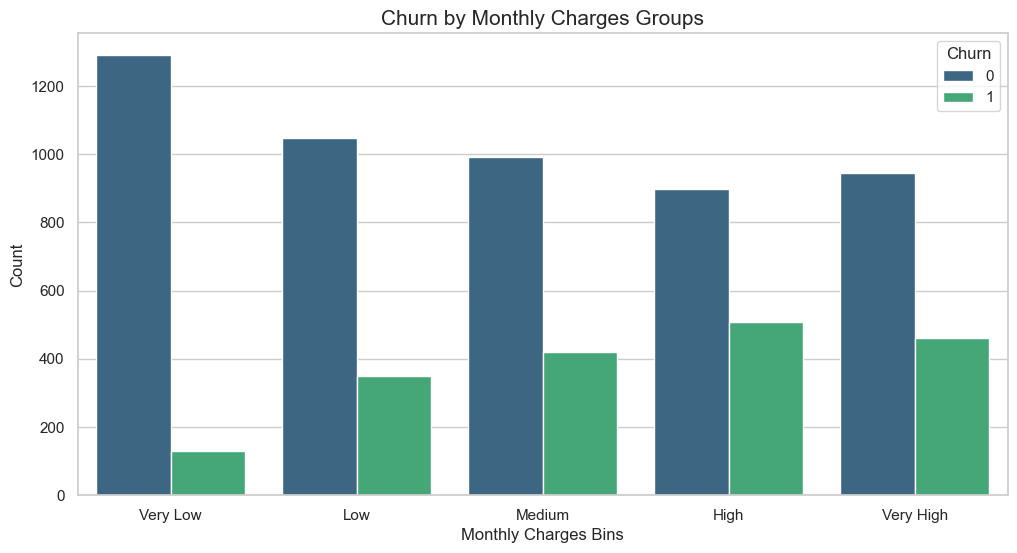

In [56]:
# Feature Engineering: Monthly Charges Bins
data['MonthlyChargesBin'] = pd.qcut(data['MonthlyCharges'], q=5,
                                   labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

plt.figure(figsize=(12, 6))
sns.countplot(x='MonthlyChargesBin', hue='Churn', data=data, palette='viridis')
plt.title('Churn by Monthly Charges Groups', fontsize=15)
plt.xlabel('Monthly Charges Bins', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Churn')
plt.show()

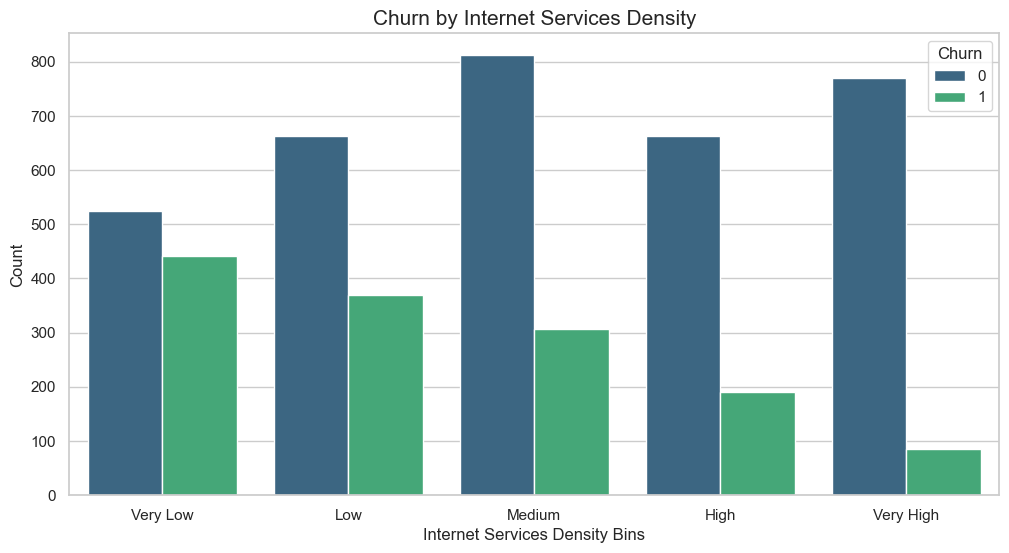

In [57]:
# Feature Engineering: InternetServicesDensity Bins
data['ServiceDensityBin'] = pd.cut(data['InternetServicesDensity'], bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
                                 labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

plt.figure(figsize=(12, 6))
sns.countplot(x='ServiceDensityBin', hue='Churn', data=data, palette='viridis')
plt.title('Churn by Internet Services Density', fontsize=15)
plt.xlabel('Internet Services Density Bins', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Churn')
plt.show()

## 2.1 EDA of anger score

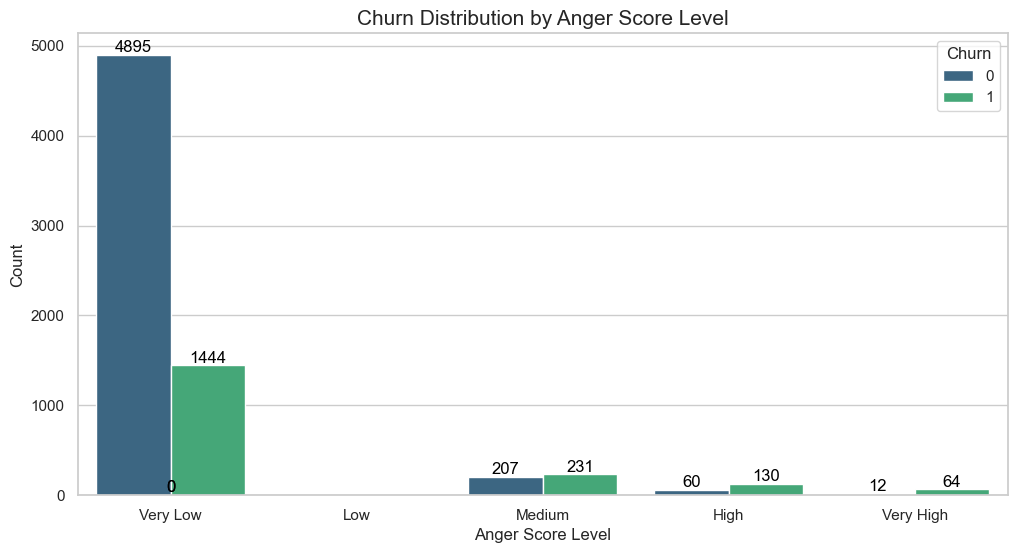

In [66]:
# Create bins for anger scores
anger_bins = [0, 2, 4, 6, 8, 10]
anger_labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

# Apply binning to the entire dataset
data['AngerBin'] = pd.cut(data['anger_score'], bins=anger_bins, labels=anger_labels, right=False)

# Create the plot
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='AngerBin', hue='Churn', data=data, palette='viridis')
plt.title('Churn Distribution by Anger Score Level', fontsize=15)
plt.xlabel('Anger Score Level', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Churn')

# Add count labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height,
            '{:d}'.format(int(height)),
            ha="center", va='bottom', color='black')

plt.show()

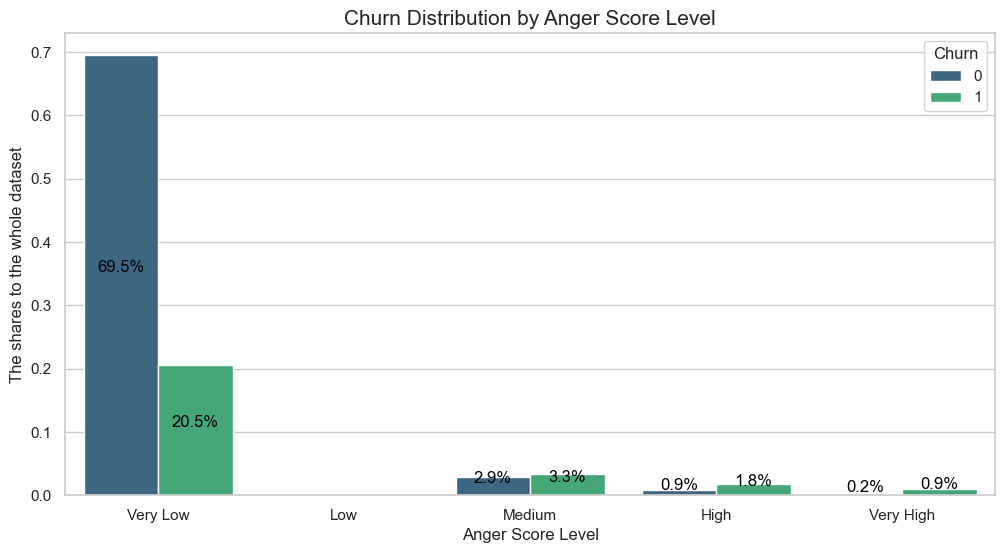

In [72]:
# Create bins for anger scores
anger_bins = [0, 2, 4, 6, 8, 10]
anger_labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

# Apply binning to the entire dataset
data['AngerBin'] = pd.cut(data['anger_score'], bins=anger_bins, labels=anger_labels, right=False)

# Create the plot
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='AngerBin', hue='Churn', data=data, palette='viridis', stat='probability')
plt.title('Churn Distribution by Anger Score Level', fontsize=15)
plt.xlabel('Anger Score Level', fontsize=12)
plt.ylabel('The shares to the whole dataset', fontsize=12)
plt.legend(title='Churn')

# Calculate and add percentage labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    width = p.get_width()
    x, y = p.get_xy()
    if height > 0:  # Only display percentages for non-zero heights
        ax.text(x + width/2,
                y + height/2,
                '{:.1f}%'.format(height * 100),
                ha='center', va='bottom', color='black')

plt.show()

Churn         0     1
AngerBin             
Very Low  0.772 0.228
Low       0.000 0.000
Medium    0.473 0.527
High      0.316 0.684
Very High 0.158 0.842


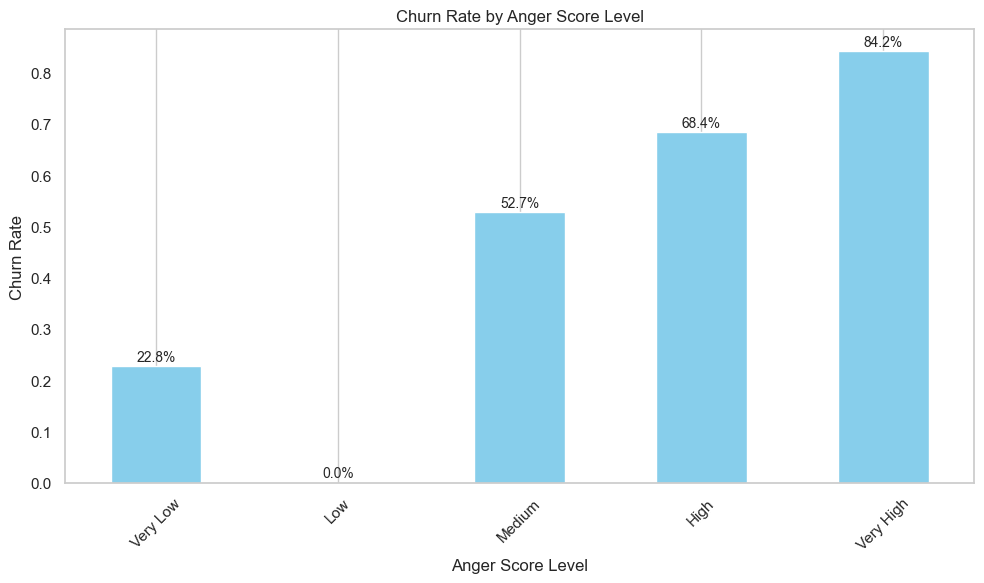

In [86]:
# Group data by AngerBin and calculate churn rate
anger_churn_rate = data.groupby('AngerBin')['Churn'].value_counts(normalize=True).unstack().fillna(0)

# Display the churn rate for each anger bin
print(anger_churn_rate)

# Plotting the churn rate by AngerBin
ax = anger_churn_rate[1].plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Churn Rate by Anger Score Level')
plt.xlabel('Anger Score Level')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Annotate bars with percentages
for p in ax.patches:
	height = p.get_height()
	ax.text(p.get_x() + p.get_width() / 2., height + 0.01, f'{height:.1%}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# 3. Data Preparation for Modeling

In [89]:
# Make a copy of the data for modeling
modeling_data = data.copy()

# Remove unnecessary columns
# Drop the CustomerID as it's just an identifier
modeling_data = modeling_data.drop(['CustomerId','AngerBin'], axis=1)

# Drop the Complaint text column, as we already have HasComplaint as a feature
if 'Complaint' in modeling_data.columns:
    modeling_data = modeling_data.drop(['Complaint'], axis=1)

# Drop the new bins we created for visualization purposes
if 'TenureBin' in modeling_data.columns:
    modeling_data = modeling_data.drop(['TenureBin'], axis=1)
if 'MonthlyChargesBin' in modeling_data.columns:
    modeling_data = modeling_data.drop(['MonthlyChargesBin'], axis=1)
if 'ServiceDensityBin' in modeling_data.columns:
    modeling_data = modeling_data.drop(['ServiceDensityBin'], axis=1)

In [90]:
# Check the shape of the modeling dataset
print(f"Shape of modeling dataset: {modeling_data.shape}")

Shape of modeling dataset: (7043, 45)


In [91]:
modeling_data.head()

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,ContractLengthMonths,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,ChangedPlan,ChangedPlanPositive,ChangedPlanNegative,InternetServicesDensity,HasComplaint,anger_score
0,Female,0,Yes,0,1,0,1,29.850,29.850,0,1,False,True,False,True,False,False,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,False,False,True,False,0,0,0,0.167,0,0.000
1,Male,0,No,0,34,1,0,56.950,1889.500,0,12,True,False,False,True,False,False,False,False,True,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,False,False,False,True,1,1,0,0.333,0,0.000
2,Male,0,No,0,2,1,1,53.850,108.150,1,1,True,False,False,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,False,False,False,True,1,0,1,0.333,0,0.000
3,Male,0,No,0,45,0,0,42.300,1840.750,0,12,False,True,False,True,False,False,False,False,True,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,True,False,False,False,1,1,0,0.500,0,0.000
4,Female,0,No,0,2,1,1,70.700,151.650,1,1,True,False,False,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,False,True,False,1,0,1,0.000,0,0.000


In [92]:
# Define categorical variable groups and their reference categories
categorical_groups = {
    'MultipleLines_': 'MultipleLines_No',  # Drop "No" as reference
    'InternetService_': 'InternetService_DSL',  # Use DSL as baseline internet service
    'OnlineSecurity_': 'OnlineSecurity_No',  # Drop "No" as reference
    'OnlineBackup_': 'OnlineBackup_No',  # Drop "No" as reference
    'DeviceProtection_': 'DeviceProtection_No',  # Drop "No" as reference
    'TechSupport_': 'TechSupport_No',  # Drop "No" as reference
    'StreamingTV_': 'StreamingTV_No',  # Drop "No" as reference
    'StreamingMovies_': 'StreamingMovies_No',  # Drop "No" as reference
    'PaymentMethod_': 'PaymentMethod_Mailed check'  # Use traditional payment as reference
}

# Drop reference categories to avoid multicollinearity
for prefix, reference in categorical_groups.items():
    if reference in modeling_data.columns:
        modeling_data = modeling_data.drop(reference, axis=1)
        print(f"Dropped {reference} as reference category")

Dropped MultipleLines_No as reference category
Dropped InternetService_DSL as reference category
Dropped OnlineSecurity_No as reference category
Dropped OnlineBackup_No as reference category
Dropped DeviceProtection_No as reference category
Dropped TechSupport_No as reference category
Dropped StreamingTV_No as reference category
Dropped StreamingMovies_No as reference category
Dropped PaymentMethod_Mailed check as reference category


In [93]:
from sklearn.preprocessing import StandardScaler

# Identify numeric columns to scale (excluding binary and target variables)
numeric_columns = ['Tenure', 'MonthlyCharges', 'TotalCharges', 'InternetServicesDensity', 'ContractLengthMonths']
scaler = StandardScaler()
modeling_data[numeric_columns] = scaler.fit_transform(modeling_data[numeric_columns])
print(f"Scaled numeric features: {numeric_columns}")

Scaled numeric features: ['Tenure', 'MonthlyCharges', 'TotalCharges', 'InternetServicesDensity', 'ContractLengthMonths']


In [94]:
# Convert Gender and Partner to numeric
modeling_data['Gender'] = modeling_data['Gender'].map({'Female': 0, 'Male': 1})
modeling_data['Partner'] = modeling_data['Partner'].map({'No': 0, 'Yes': 1})

In [95]:
# Convert all boolean columns to integers (True->1, False->0)
bool_columns = modeling_data.select_dtypes(include=['bool']).columns
for col in bool_columns:
    modeling_data[col] = modeling_data[col].astype(int)

In [96]:
modeling_data.head()

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,ContractLengthMonths,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,ChangedPlan,ChangedPlanPositive,ChangedPlanNegative,InternetServicesDensity,HasComplaint,anger_score
0,0,0,1,0,-1.277,0,1,-1.160,-0.993,0,-0.820,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.562,0,0.000
1,1,0,0,0,0.066,1,0,-0.260,-0.172,0,0.331,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,-0.021,0,0.000
2,1,0,0,0,-1.237,1,1,-0.363,-0.958,1,-0.820,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,-0.021,0,0.000
3,1,0,0,0,0.514,0,0,-0.747,-0.194,0,0.331,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0.521,0,0.000
4,0,0,0,0,-1.237,1,1,0.197,-0.939,1,-0.820,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,-1.103,0,0.000


# 4. Modelling


## 4.1 Train-Test Split

In [97]:
# Separate features and target variable
X = modeling_data.drop('Churn', axis=1)
y = modeling_data['Churn']

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")



Train set: 5282 samples
Test set: 1761 samples


## 4.2 Define Evaluation Metrics and Functions

In [98]:
# Custom cost function: False negatives are more costly than false positives
def calculate_business_cost(y_true, y_pred, fn_cost=5, fp_cost=1):
    """
    Calculate the business cost of prediction errors.

    Args:
        y_true: True labels
        y_pred: Predicted labels
        fn_cost: Cost of a false negative (missed churn) - default 5x more expensive
        fp_cost: Cost of a false positive (false alarm)

    Returns:
        Total business cost
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    total_cost = (fp * fp_cost) + (fn * fn_cost)
    return total_cost

# Custom F2 score (emphasizes recall over precision)
def f2_score(y_true, y_pred):
    """Calculate F2 score which weighs recall higher than precision."""
    return fbeta_score(y_true, y_pred, beta=2)

# Utility function to plot confusion matrix with business costs
def plot_confusion_matrix(y_true, y_pred, fn_cost=5, fp_cost=1, title=''):
    """Plot confusion matrix with business costs."""
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    total_cost = (fp * fp_cost) + (fn * fn_cost)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{title}\nBusiness Cost: ${total_cost:,}', fontsize=14)
    plt.ylabel('Actual', fontsize=12)
    plt.xlabel('Predicted', fontsize=12)

    # Add cost annotations
    plt.text(0.5, 0.3, f'Cost: $0', ha='center', va='center', fontsize=12)
    plt.text(1.5, 0.3, f'Cost: ${fp*fp_cost:,}', ha='center', va='center', fontsize=12, color='orange')
    plt.text(0.5, 1.3, f'Cost: ${fn*fn_cost:,}', ha='center', va='center', fontsize=12, color='red')
    plt.text(1.5, 1.3, f'Cost: $0', ha='center', va='center', fontsize=12)

    # Add FN and FP rates
    n_positives = fn + tp
    n_negatives = tn + fp
    fn_rate = fn / n_positives if n_positives > 0 else 0
    fp_rate = fp / n_negatives if n_negatives > 0 else 0

    plt.text(0.5, 0.7, f'TNR: {tn/n_negatives:.2%}', ha='center', va='center', fontsize=11)
    plt.text(1.5, 0.7, f'FPR: {fp_rate:.2%}', ha='center', va='center', fontsize=11, color = 'orange')
    plt.text(0.5, 1.7, f'FNR: {fn_rate:.2%}', ha='center', va='center', fontsize=11, color='red')
    plt.text(1.5, 1.7, f'TPR: {tp/n_positives:.2%}', ha='center', va='center', fontsize=11)

    plt.show()

# Function to evaluate and report model performance
def evaluate_model(model, X_test, y_test, X_train=None, y_train=None, show_plots=True):
    """
    Evaluate model performance with key metrics.

    Args:
        model: Trained model
        X_test, y_test: Test data
        X_train, y_train: Optional training data for comparison
        show_plots: Whether to display performance plots

    Returns:
        Dictionary of performance metrics
    """
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)
    business_cost = calculate_business_cost(y_test, y_pred)

    # ROC AUC if probability predictions are available
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    # Print results
    print(f"\n--- Model: {model.__class__.__name__} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"F2 Score: {f2:.4f}")
    if roc_auc is not None:
        print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Business Cost: ${business_cost:,}")

    # Confusion matrix and report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    if show_plots:
        # Plot confusion matrix
        plot_confusion_matrix(y_test, y_pred, title=f'Confusion Matrix: {model.__class__.__name__}')

        # Plot ROC curve if probability predictions are available
        if y_pred_proba is not None:
            plt.figure(figsize=(8, 6))
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve: {model.__class__.__name__}')
            plt.legend(loc='lower right')
            plt.show()

            # Plot precision-recall curve
            precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
            plt.figure(figsize=(8, 6))
            plt.plot(recall_curve, precision_curve)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title(f'Precision-Recall Curve: {model.__class__.__name__}')
            plt.show()

            # If training data is provided, check for overfitting
            if X_train is not None and y_train is not None:
                y_train_pred = model.predict(X_train)
                train_accuracy = accuracy_score(y_train, y_train_pred)
                train_recall = recall_score(y_train, y_train_pred)

                print("\nTraining vs Test Performance:")
                print(f"Training Accuracy: {train_accuracy:.4f}, Test Accuracy: {accuracy:.4f}")
                print(f"Training Recall: {train_recall:.4f}, Test Recall: {recall:.4f}")
                print(f"Accuracy Difference: {train_accuracy - accuracy:.4f}")
                print(f"Recall Difference: {train_recall - recall:.4f}")

    # Return metrics dictionary
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'f2': f2,
        'roc_auc': roc_auc,
        'business_cost': business_cost
    }

## 4.3 Business Rule


===== Model 1: Business Rules Baseline =====

--- Model: BusinessRulesModel ---
Accuracy: 0.5531
Precision: 0.3680
Recall: 0.9550
F1 Score: 0.5313
F2 Score: 0.7240
ROC AUC: 0.6815
Business Cost: $871

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.41      0.57      1294
           1       0.37      0.96      0.53       467

    accuracy                           0.55      1761
   macro avg       0.66      0.68      0.55      1761
weighted avg       0.80      0.55      0.56      1761



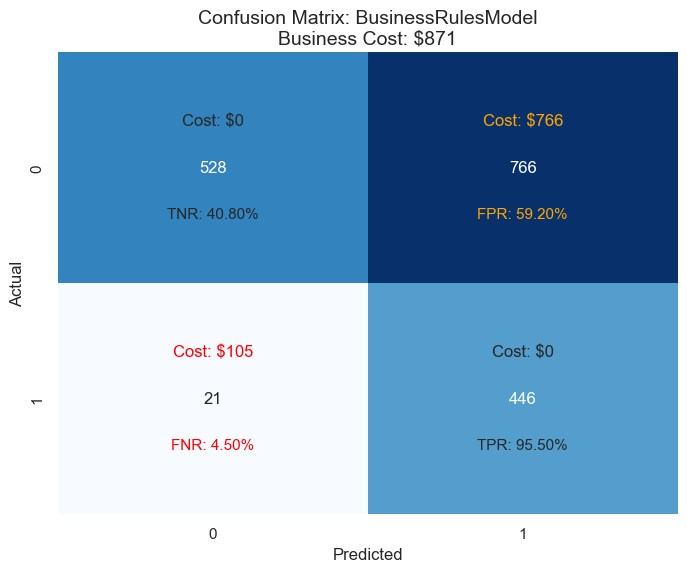

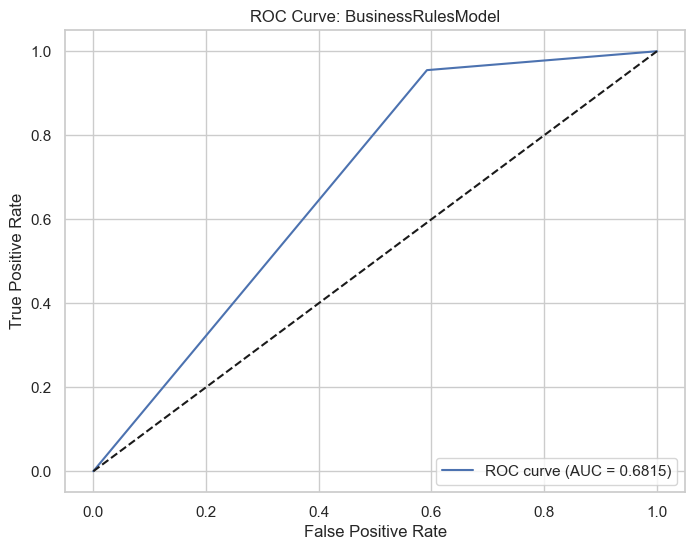

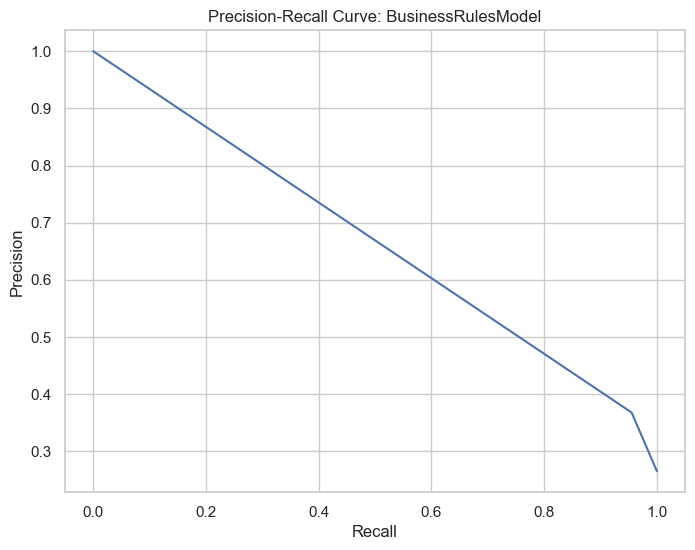

In [99]:
print("\n===== Model 1: Business Rules Baseline =====")

class BusinessRulesModel:
    def __init__(self):
        self.feature_importance_ = None

    def fit(self, X, y):
        # Calculate feature importance based on correlation with target
        corr_with_target = X.corrwith(y).abs().sort_values(ascending=False)
        self.feature_importance_ = corr_with_target
        return self

    def predict(self, X):
        """Predict using simple business rules:
        - Low tenure (below -0.5 std) OR
        - Month-to-month contract OR
        - Has complaint OR
        - High monthly charges (above 0.5 std) AND no online security
        """
        # Rule 1: Low tenure customers
        rule1 = X['Tenure'] < -0.5

        # Rule 2: Month-to-month contract (ContractLengthMonths = 1)
        rule2 = X['ContractLengthMonths'] <= -0.8  # Standardized value for 1 month

        # Rule 3: Customers with complaints
        rule3 = X['HasComplaint'] == 1

        # Rule 4: High monthly charges AND no online security
        high_charges = X['MonthlyCharges'] > 0.5
        no_security = X['OnlineSecurity_Yes'] == 0 if 'OnlineSecurity_Yes' in X.columns else True
        rule4 = high_charges & no_security

        # Combine rules
        predictions = np.zeros(len(X))
        predictions[(rule1 | rule2 | rule3 | rule4)] = 1

        return predictions

    def predict_proba(self, X):
        # Simple probability estimate (not calibrated)
        pred = self.predict(X)
        proba = np.zeros((len(X), 2))
        proba[:, 1] = pred  # Set to 0 or 1
        proba[:, 0] = 1 - pred
        return proba

# Train and evaluate business rules model
business_model = BusinessRulesModel()
business_model.fit(X_train, y_train)
business_metrics = evaluate_model(business_model, X_test, y_test)


## 4.4 Logistic Regression Baseline


===== Model 2: Logistic Regression Baseline =====

--- Model: LogisticRegression ---
Accuracy: 0.8160
Precision: 0.6970
Recall: 0.5418
F1 Score: 0.6096
F2 Score: 0.5670
ROC AUC: 0.8673
Business Cost: $1,180

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1294
           1       0.70      0.54      0.61       467

    accuracy                           0.82      1761
   macro avg       0.77      0.73      0.74      1761
weighted avg       0.81      0.82      0.81      1761



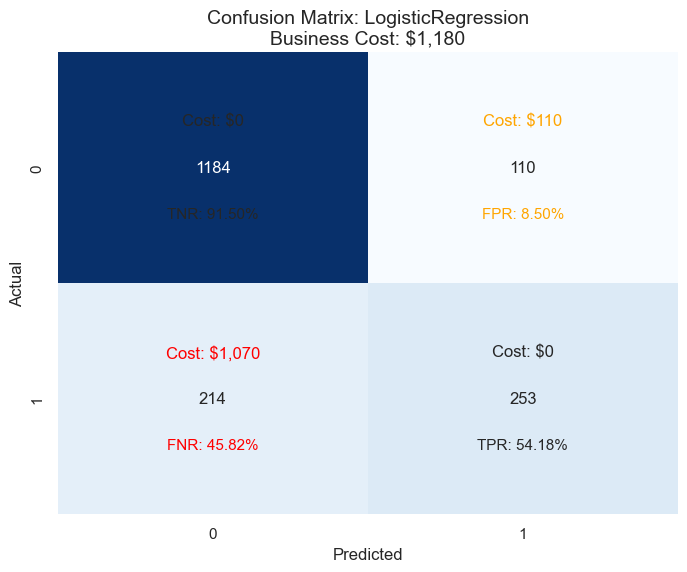

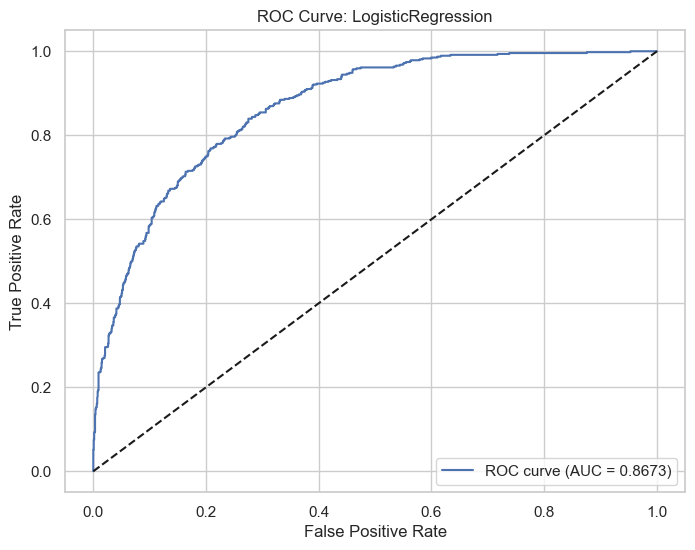

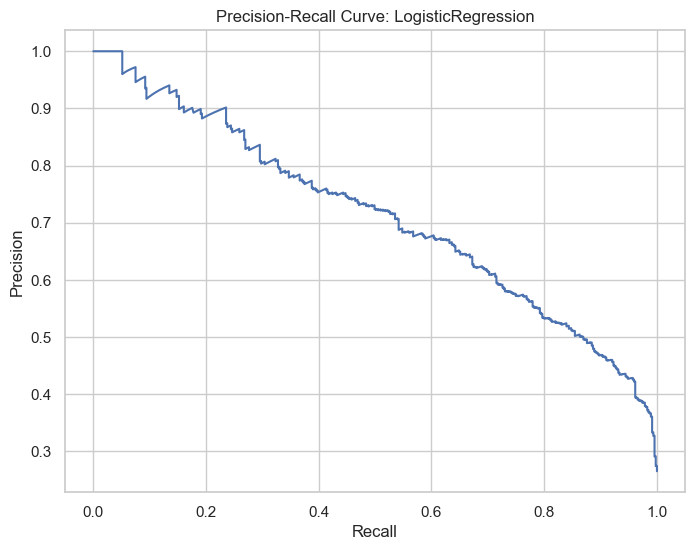


Training vs Test Performance:
Training Accuracy: 0.8200, Test Accuracy: 0.8160
Training Recall: 0.5599, Test Recall: 0.5418
Accuracy Difference: 0.0039
Recall Difference: 0.0182


In [100]:
print("\n===== Model 2: Logistic Regression Baseline =====")

# Train a basic logistic regression model
logreg_baseline = LogisticRegression(random_state=42)
logreg_baseline.fit(X_train, y_train)
logreg_metrics = evaluate_model(logreg_baseline, X_test, y_test, X_train, y_train)


## 4.5 Logistic Regression with Regularization (L1/LASSO)


===== Model 3: Logistic Regression with L1 Regularization =====
Best C value from cross-validation: 100

--- Model: LogisticRegression ---
Accuracy: 0.8177
Precision: 0.7017
Recall: 0.5439
F1 Score: 0.6128
F2 Score: 0.5695
ROC AUC: 0.8665
Business Cost: $1,173

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      1294
           1       0.70      0.54      0.61       467

    accuracy                           0.82      1761
   macro avg       0.77      0.73      0.75      1761
weighted avg       0.81      0.82      0.81      1761



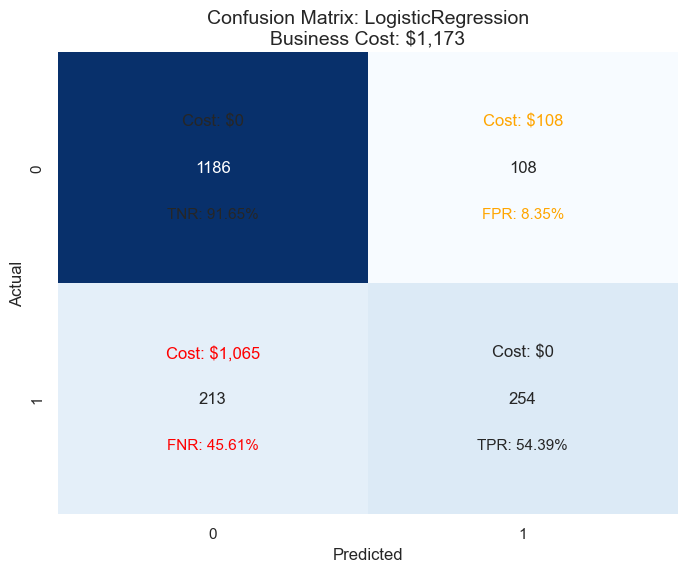

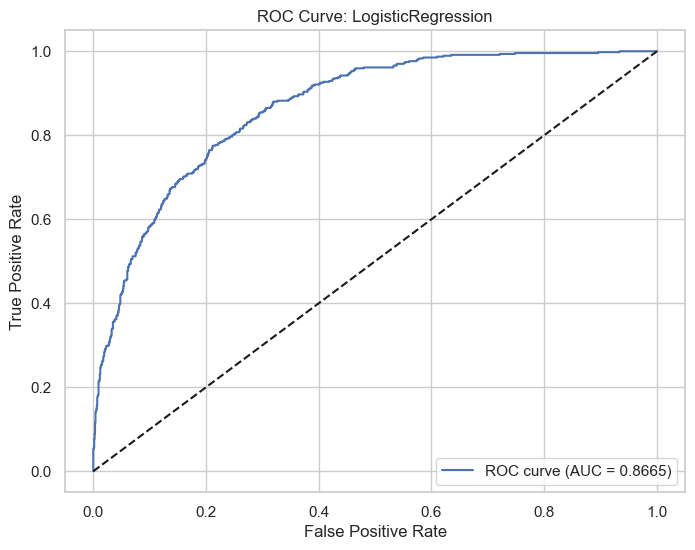

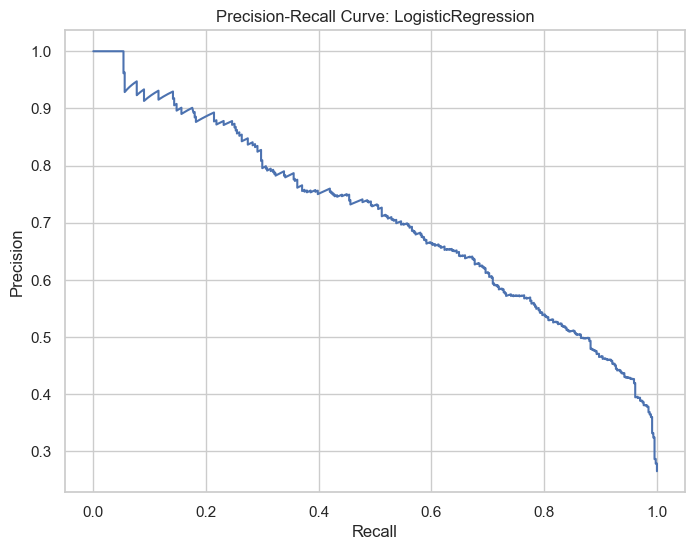


Training vs Test Performance:
Training Accuracy: 0.8207, Test Accuracy: 0.8177
Training Recall: 0.5635, Test Recall: 0.5439
Accuracy Difference: 0.0030
Recall Difference: 0.0196

Top features by coefficient magnitude:
                             Feature  Coefficient
12       InternetService_Fiber optic        2.907
33                      HasComplaint       -2.596
7                     MonthlyCharges       -2.460
10    MultipleLines_No phone service       -2.112
16  OnlineBackup_No internet service       -1.717
32           InternetServicesDensity        1.467
5                       PhoneService       -0.919
4                             Tenure       -0.794
34                       anger_score        0.766
21                   TechSupport_Yes       -0.763


In [101]:
print("\n===== Model 3: Logistic Regression with L1 Regularization =====")

# Cross-validation to find the best C value
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
cv_scores = []

for C in C_values:
    model = LogisticRegression(penalty='l1', C=C, solver='liblinear', random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    cv_scores.append((C, scores.mean()))

best_C = max(cv_scores, key=lambda x: x[1])[0]
print(f"Best C value from cross-validation: {best_C}")

# Train the model with the best C value
logreg_l1 = LogisticRegression(penalty='l1', C=best_C, solver='liblinear', random_state=42)
logreg_l1.fit(X_train, y_train)
logreg_l1_metrics = evaluate_model(logreg_l1, X_test, y_test, X_train, y_train)

# Look at the coefficients for feature importance
print("\nTop features by coefficient magnitude:")
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': logreg_l1.coef_[0]
})
print(coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index).head(10))


## 4.6 Decision Tree


===== Model 4: Decision Tree =====
Best max_depth from cross-validation: 7

--- Model: DecisionTreeClassifier ---
Accuracy: 0.7995
Precision: 0.7159
Recall: 0.4047
F1 Score: 0.5171
F2 Score: 0.4432
ROC AUC: 0.8370
Business Cost: $1,465

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.94      0.87      1294
           1       0.72      0.40      0.52       467

    accuracy                           0.80      1761
   macro avg       0.77      0.67      0.70      1761
weighted avg       0.79      0.80      0.78      1761



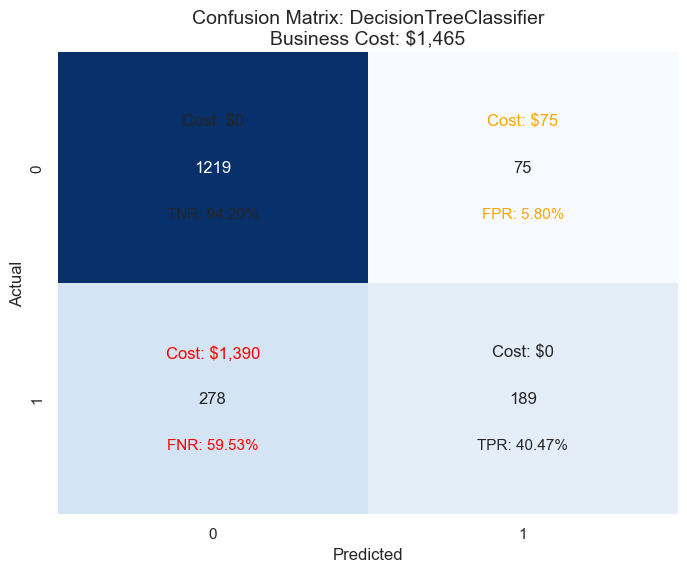

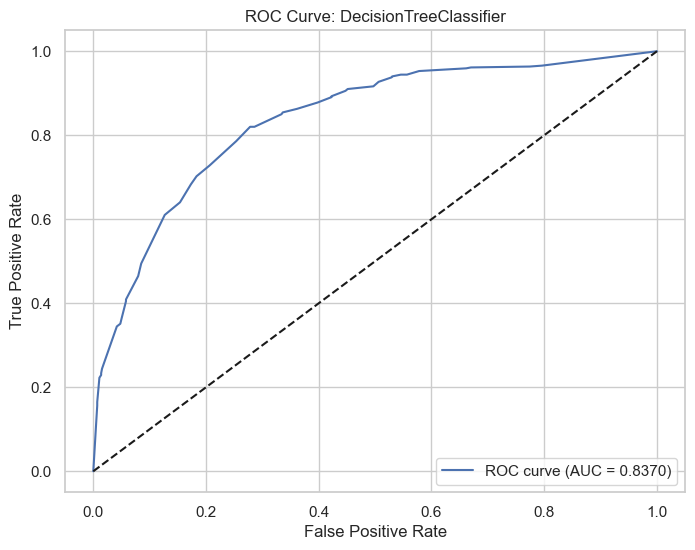

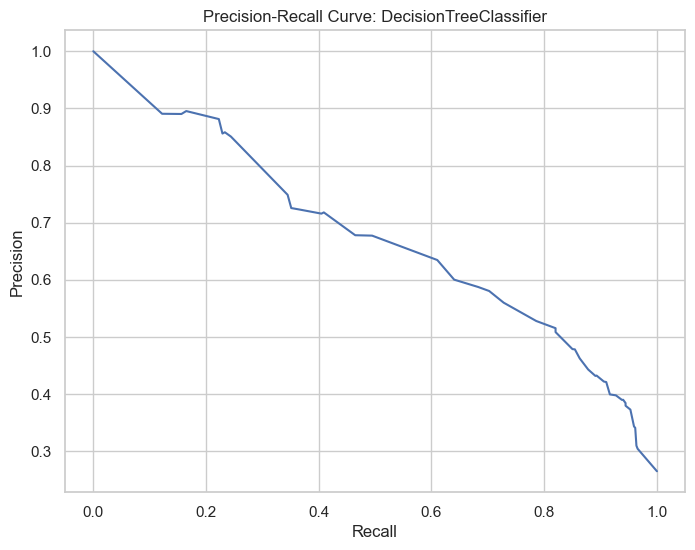


Training vs Test Performance:
Training Accuracy: 0.8296, Test Accuracy: 0.7995
Training Recall: 0.4772, Test Recall: 0.4047
Accuracy Difference: 0.0301
Recall Difference: 0.0725


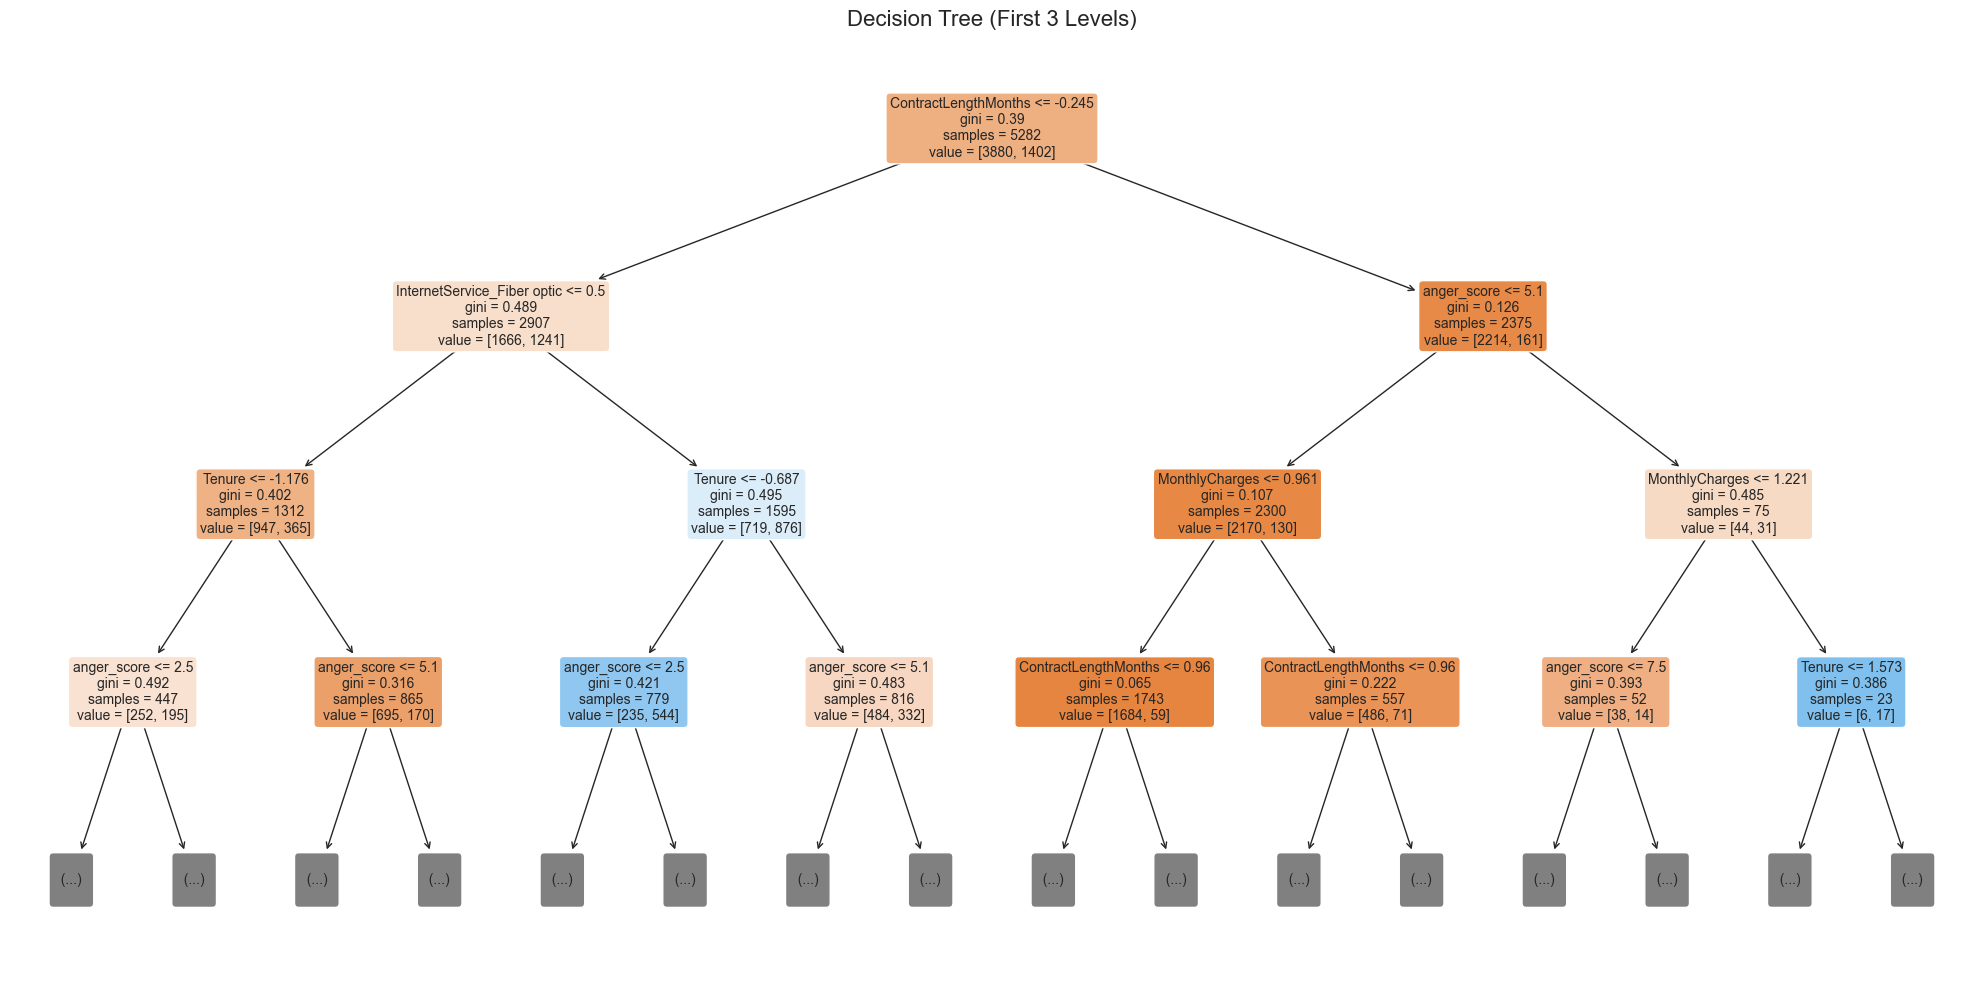


Top 10 features by importance (Decision Tree):
                                Feature  Importance
9                  ContractLengthMonths       0.409
4                                Tenure       0.141
12          InternetService_Fiber optic       0.126
34                          anger_score       0.117
8                          TotalCharges       0.060
7                        MonthlyCharges       0.056
28       PaymentMethod_Electronic check       0.013
21                      TechSupport_Yes       0.011
24  StreamingMovies_No internet service       0.010
32              InternetServicesDensity       0.010


In [102]:
print("\n===== Model 4: Decision Tree =====")

# Cross-validation to find the best max_depth
depth_values = [3, 4, 5, 6, 7, 8, 10, 12, 15, 20]
dt_cv_scores = []

for depth in depth_values:
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    dt_cv_scores.append((depth, scores.mean()))

best_depth = max(dt_cv_scores, key=lambda x: x[1])[0]
print(f"Best max_depth from cross-validation: {best_depth}")

# Train the model with the best max_depth
dt_model = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
dt_model.fit(X_train, y_train)
dt_metrics = evaluate_model(dt_model, X_test, y_test, X_train, y_train)

# Visualize decision tree (limited to first few levels)
plt.figure(figsize=(20, 10))
plot_tree(dt_model, max_depth=3, feature_names=X_train.columns,
          filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree (First 3 Levels)', fontsize=16)
plt.tight_layout()
plt.show()

# Decision tree feature importance
dt_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': dt_model.feature_importances_
})
print("\nTop 10 features by importance (Decision Tree):")
print(dt_feature_importance.sort_values('Importance', ascending=False).head(10))

## 4.7 Random Forest


===== Model 5: Random Forest =====

--- Model: RandomForestClassifier ---
Accuracy: 0.8052
Precision: 0.6813
Recall: 0.4989
F1 Score: 0.5760
F2 Score: 0.5271
ROC AUC: 0.8445
Business Cost: $1,279

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.92      0.87      1294
           1       0.68      0.50      0.58       467

    accuracy                           0.81      1761
   macro avg       0.76      0.71      0.72      1761
weighted avg       0.79      0.81      0.79      1761



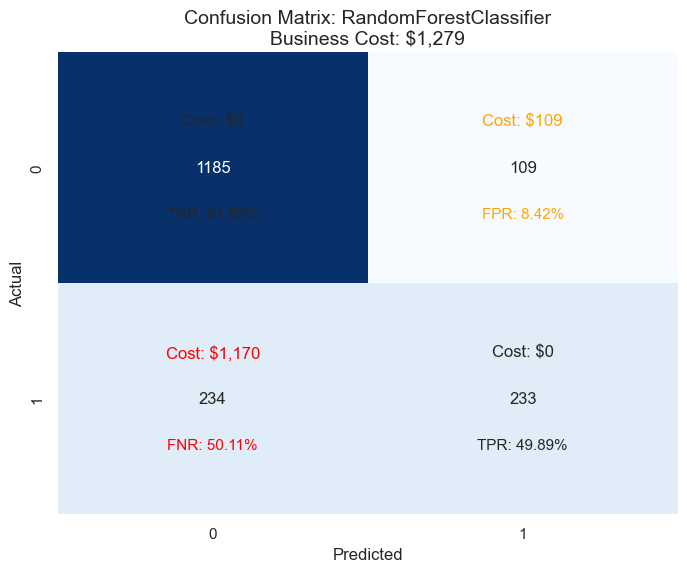

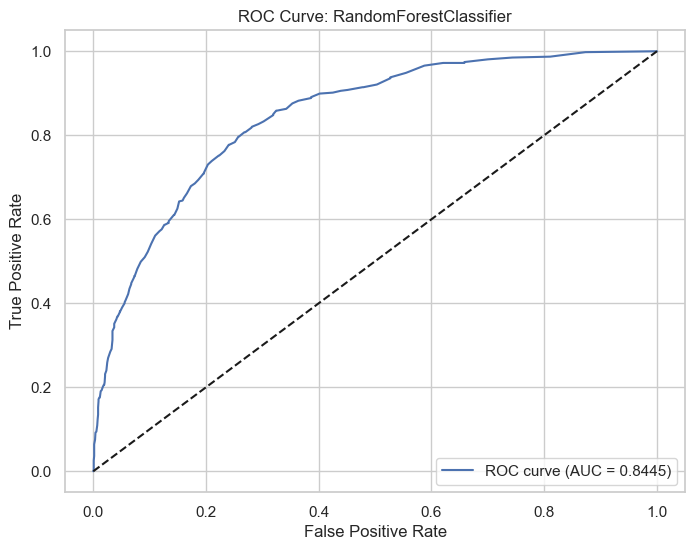

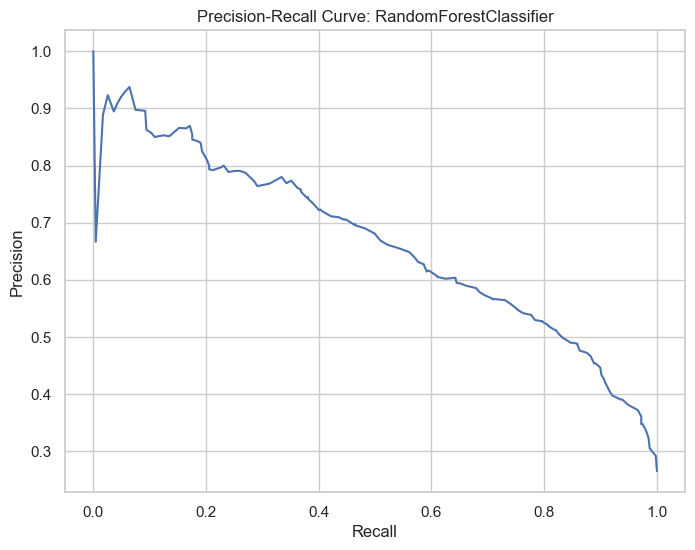


Training vs Test Performance:
Training Accuracy: 0.9983, Test Accuracy: 0.8052
Training Recall: 0.9964, Test Recall: 0.4989
Accuracy Difference: 0.1931
Recall Difference: 0.4975

Top 10 features by importance (Random Forest):
                           Feature  Importance
8                     TotalCharges       0.155
7                   MonthlyCharges       0.137
4                           Tenure       0.131
9             ContractLengthMonths       0.061
32         InternetServicesDensity       0.041
34                     anger_score       0.038
28  PaymentMethod_Electronic check       0.038
12     InternetService_Fiber optic       0.037
0                           Gender       0.026
33                    HasComplaint       0.025


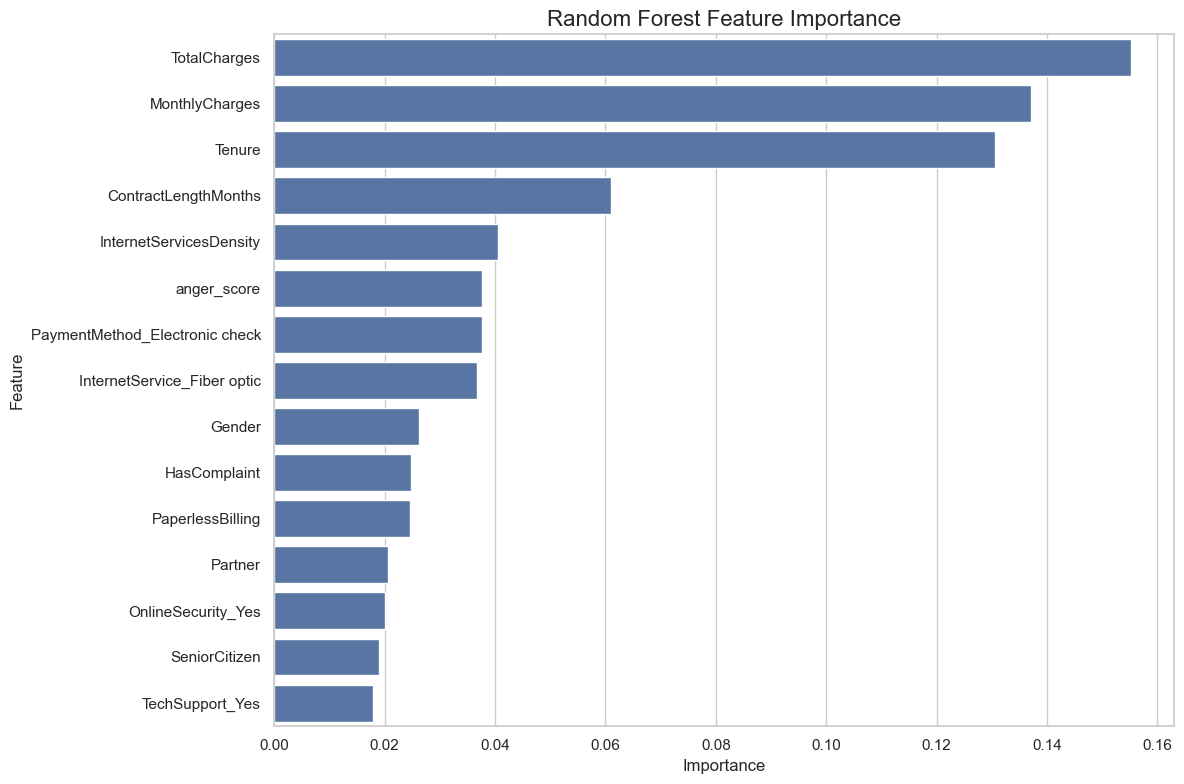

In [103]:
print("\n===== Model 5: Random Forest =====")

# Start with a baseline Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_metrics = evaluate_model(rf_model, X_test, y_test, X_train, y_train)

# Random forest feature importance
rf_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
})
print("\nTop 10 features by importance (Random Forest):")
print(rf_feature_importance.sort_values('Importance', ascending=False).head(10))

# Plot feature importance
plt.figure(figsize=(12, 8))
rf_importance_plot = rf_feature_importance.sort_values('Importance', ascending=False).head(15)
sns.barplot(x='Importance', y='Feature', data=rf_importance_plot)
plt.title('Random Forest Feature Importance', fontsize=16)
plt.tight_layout()
plt.show()


## 4.8 Gradient Boosting


===== Model 6: Gradient Boosting =====

--- Model: GradientBoostingClassifier ---
Accuracy: 0.8132
Precision: 0.6994
Recall: 0.5182
F1 Score: 0.5953
F2 Score: 0.5465
ROC AUC: 0.8640
Business Cost: $1,229

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1294
           1       0.70      0.52      0.60       467

    accuracy                           0.81      1761
   macro avg       0.77      0.72      0.74      1761
weighted avg       0.80      0.81      0.80      1761



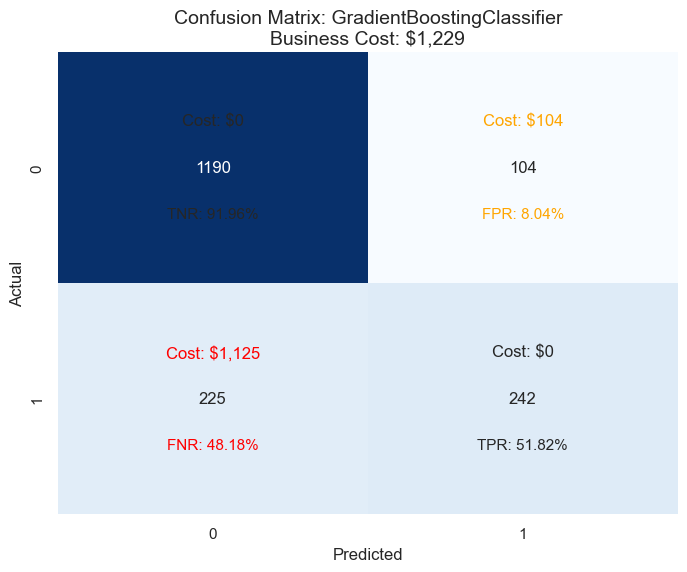

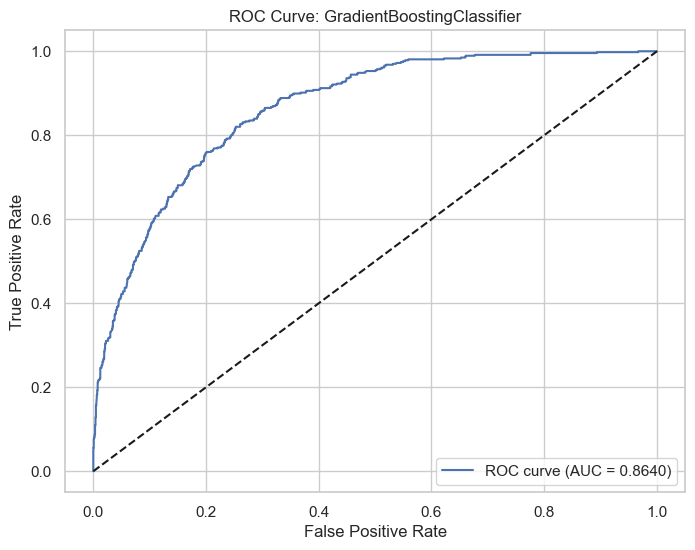

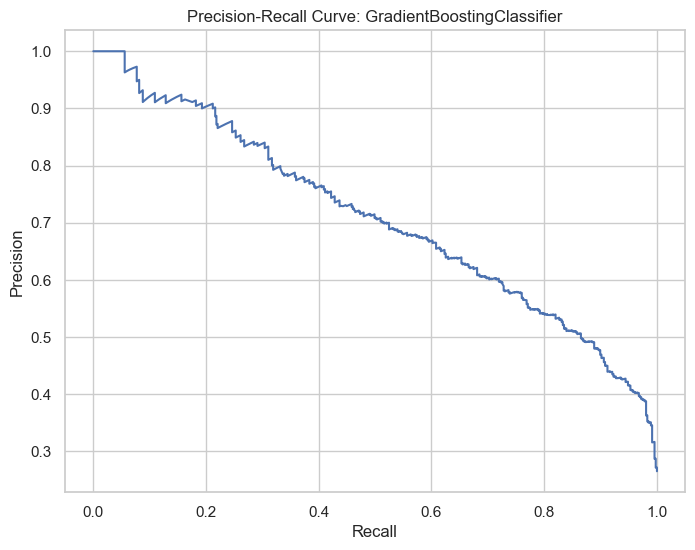


Training vs Test Performance:
Training Accuracy: 0.8395, Test Accuracy: 0.8132
Training Recall: 0.5927, Test Recall: 0.5182
Accuracy Difference: 0.0263
Recall Difference: 0.0745

Top 10 features by importance (Gradient Boosting):
                           Feature  Importance
9             ContractLengthMonths       0.356
4                           Tenure       0.125
12     InternetService_Fiber optic       0.103
34                     anger_score       0.079
7                   MonthlyCharges       0.056
33                    HasComplaint       0.053
8                     TotalCharges       0.050
28  PaymentMethod_Electronic check       0.045
29                     ChangedPlan       0.022
6                 PaperlessBilling       0.018


In [104]:
print("\n===== Model 6: Gradient Boosting =====")

# Baseline Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
gb_metrics = evaluate_model(gb_model, X_test, y_test, X_train, y_train)

# Feature importance
gb_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': gb_model.feature_importances_
})
print("\nTop 10 features by importance (Gradient Boosting):")
print(gb_feature_importance.sort_values('Importance', ascending=False).head(10))


## 4.9 XGBoost with Hyperparameter Tuning

In [105]:
print("\n===== Model 7: XGBoost with Hyperparameter Tuning =====")

# First train a basic XGBoost model
xgb_model_basic = xgb.XGBClassifier(random_state=42)
xgb_model_basic.fit(X_train, y_train)
xgb_basic_metrics = evaluate_model(xgb_model_basic, X_test, y_test, X_train, y_train, show_plots=False)

# Hyperparameter tuning with Grid Search
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1, 3, 5]  # To handle class imbalance
}

# Use make_scorer to create a scorer for F2
from sklearn.metrics import make_scorer
f2_scorer = make_scorer(f2_score) # Assuming f2_score is defined earlier

grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(random_state=42),
    param_grid=param_grid,
    scoring=f2_scorer,  # Use the f2_scorer here
    cv=3,
    verbose=1
)

grid_search.fit(X_train, y_train)  # Use original training data for tuning

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best F2 score: {grid_search.best_score_:.4f}")


===== Model 7: XGBoost with Hyperparameter Tuning =====

--- Model: XGBClassifier ---
Accuracy: 0.8001
Precision: 0.6533
Recall: 0.5246
F1 Score: 0.5819
F2 Score: 0.5461
ROC AUC: 0.8359
Business Cost: $1,240

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1294
           1       0.65      0.52      0.58       467

    accuracy                           0.80      1761
   macro avg       0.75      0.71      0.73      1761
weighted avg       0.79      0.80      0.79      1761

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'scale_pos_weight': 5, 'subsample': 0.8}
Best F2 score: 0.7602



--- Model: XGBClassifier ---
Accuracy: 0.6996
Precision: 0.4657
Recall: 0.9015
F1 Score: 0.6142
F2 Score: 0.7594
ROC AUC: 0.8662
Business Cost: $713

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.63      0.75      1294
           1       0.47      0.90      0.61       467

    accuracy                           0.70      1761
   macro avg       0.71      0.76      0.68      1761
weighted avg       0.82      0.70      0.72      1761



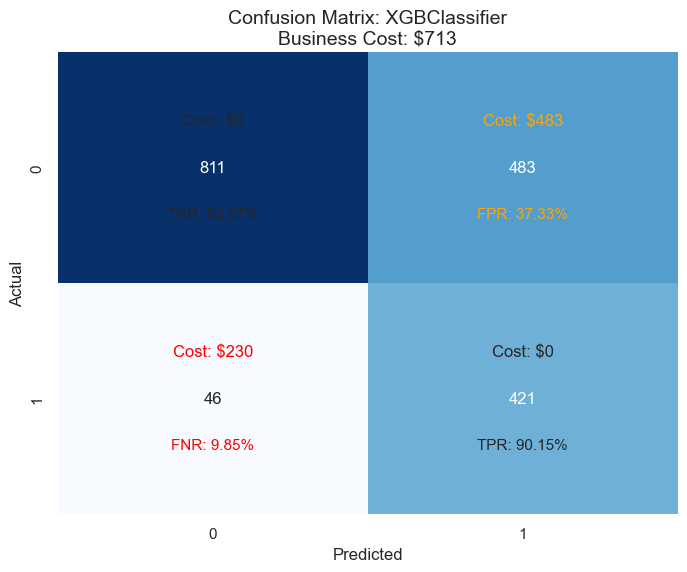

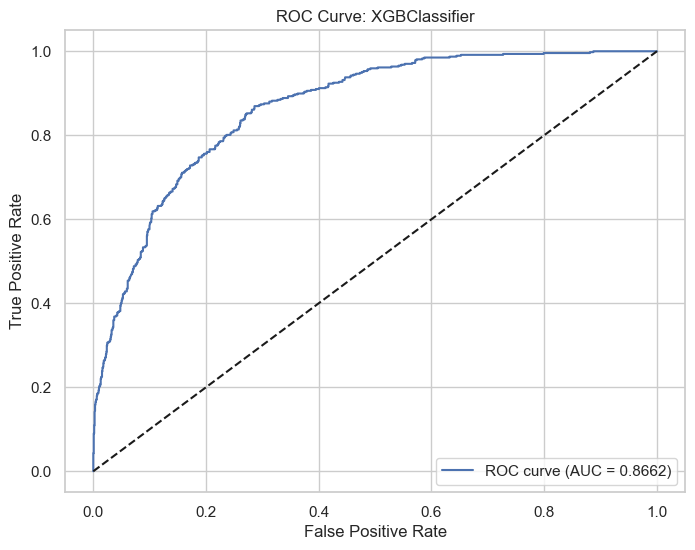

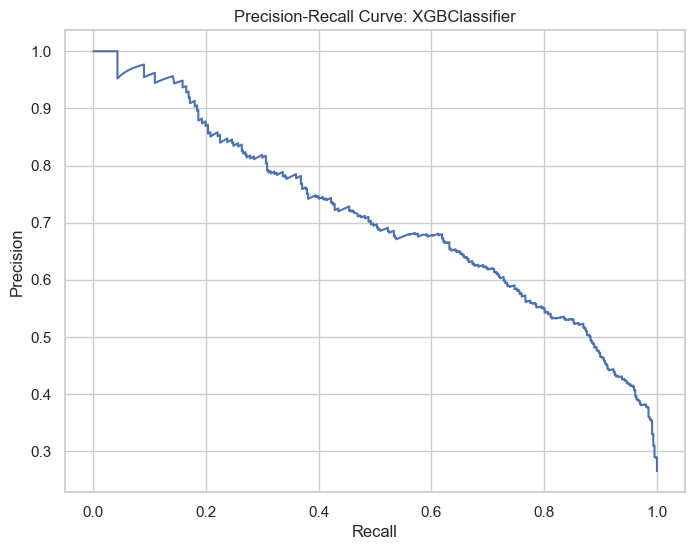


Training vs Test Performance:
Training Accuracy: 0.7122, Test Accuracy: 0.6996
Training Recall: 0.9344, Test Recall: 0.9015
Accuracy Difference: 0.0126
Recall Difference: 0.0329

Top 10 features by importance (XGBoost):
                               Feature  Importance
9                 ContractLengthMonths       0.305
12         InternetService_Fiber optic       0.132
14  OnlineSecurity_No internet service       0.066
13                  InternetService_No       0.046
25                 StreamingMovies_Yes       0.039
4                               Tenure       0.038
33                        HasComplaint       0.030
34                         anger_score       0.028
29                         ChangedPlan       0.026
28      PaymentMethod_Electronic check       0.024


In [106]:
# Train final XGBoost model with best parameters
xgb_model = grid_search.best_estimator_

# Retrain on resampled data with best parameters
xgb_model = xgb.XGBClassifier(
    random_state=42,
    **grid_search.best_params_
)
xgb_model.fit(X_train, y_train)
xgb_metrics = evaluate_model(xgb_model, X_test, y_test, X_train, y_train)

# Feature importance (note XGBoost reports gain importance)
xgb_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
})
print("\nTop 10 features by importance (XGBoost):")
print(xgb_feature_importance.sort_values('Importance', ascending=False).head(10))

# 5. Model Comparison


===== Model Comparison =====

Model Comparison:
                      Model  Accuracy  Precision  Recall  F1 Score  F2 Score  \
0            Business Rules     0.553      0.368   0.955     0.531     0.724   
1       Logistic Regression     0.810      0.686   0.525     0.595     0.551   
2  Logistic Regression (L1)     0.811      0.684   0.533     0.599     0.558   
3             Decision Tree     0.798      0.703   0.411     0.519     0.448   
4             Random Forest     0.800      0.661   0.501     0.570     0.527   
5         Gradient Boosting     0.811      0.690   0.520     0.593     0.547   
6                   XGBoost     0.717      0.481   0.887     0.624     0.759   

   ROC AUC  Business Cost  
0    0.682            871  
1    0.865           1222  
2    0.863           1205  
3    0.828           1456  
4    0.843           1285  
5    0.861           1229  
6    0.861            711  


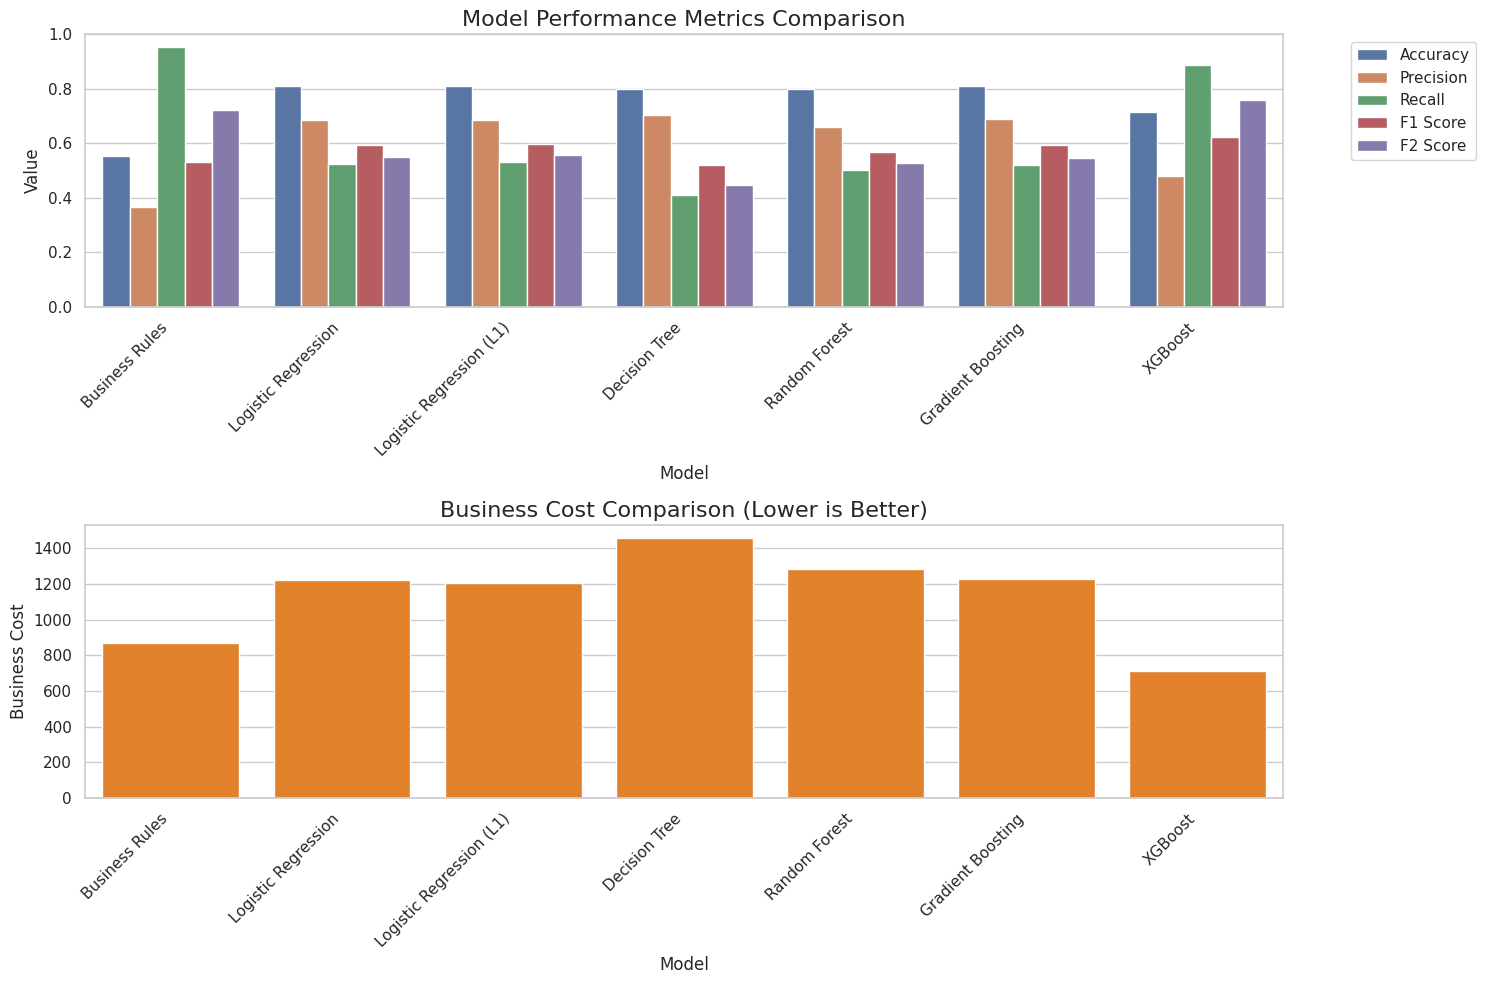

In [ ]:
print("\n===== Model Comparison =====")

# Collect all model metrics
model_names = [
    'Business Rules',
    'Logistic Regression',
    'Logistic Regression (L1)',
    'Decision Tree',
    'Random Forest',
    'Gradient Boosting',
    'XGBoost'
]

model_metrics = [
    business_metrics,
    logreg_metrics,
    logreg_l1_metrics,
    dt_metrics,
    rf_metrics,
    gb_metrics,
    xgb_metrics
]

# Create comparison dataframe
metrics_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': [m['accuracy'] for m in model_metrics],
    'Precision': [m['precision'] for m in model_metrics],
    'Recall': [m['recall'] for m in model_metrics],
    'F1 Score': [m['f1'] for m in model_metrics],
    'F2 Score': [m['f2'] for m in model_metrics],
    'ROC AUC': [m['roc_auc'] for m in model_metrics],
    'Business Cost': [m['business_cost'] for m in model_metrics]
})

print("\nModel Comparison:")
print(metrics_df)

# Plot the metrics for visual comparison
plt.figure(figsize=(15, 10))

# Plot accuracy, precision, recall, F1, F2
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score']
metrics_data = metrics_df[['Model'] + metrics_to_plot].melt(id_vars='Model', var_name='Metric', value_name='Value')

plt.subplot(2, 1, 1)
sns.barplot(x='Model', y='Value', hue='Metric', data=metrics_data)
plt.title('Model Performance Metrics Comparison', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot business cost (lower is better)
plt.subplot(2, 1, 2)
sns.barplot(x='Model', y='Business Cost', data=metrics_df, color='#ff7f0e')
plt.title('Business Cost Comparison (Lower is Better)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 6. Model Interpretation



# 6.1 Feature Importance Comparison


===== Feature Importance Comparison =====

Top 15 features by average importance rank across models:
                           Feature  Average Rank  Logistic Regression  \
12     InternetService_Fiber optic         3.400                2.913   
4                           Tenure         4.200                0.814   
33                    HasComplaint         4.400                1.698   
9             ContractLengthMonths         4.600                0.582   
7                   MonthlyCharges         5.800                2.446   
28  PaymentMethod_Electronic check         9.800                0.285   
21                 TechSupport_Yes        10.200                0.807   
8                     TotalCharges        10.800                0.156   
6                 PaperlessBilling        11.800                0.428   
32         InternetServicesDensity        12.400                1.562   
29                     ChangedPlan        13.200                0.728   
15              Online

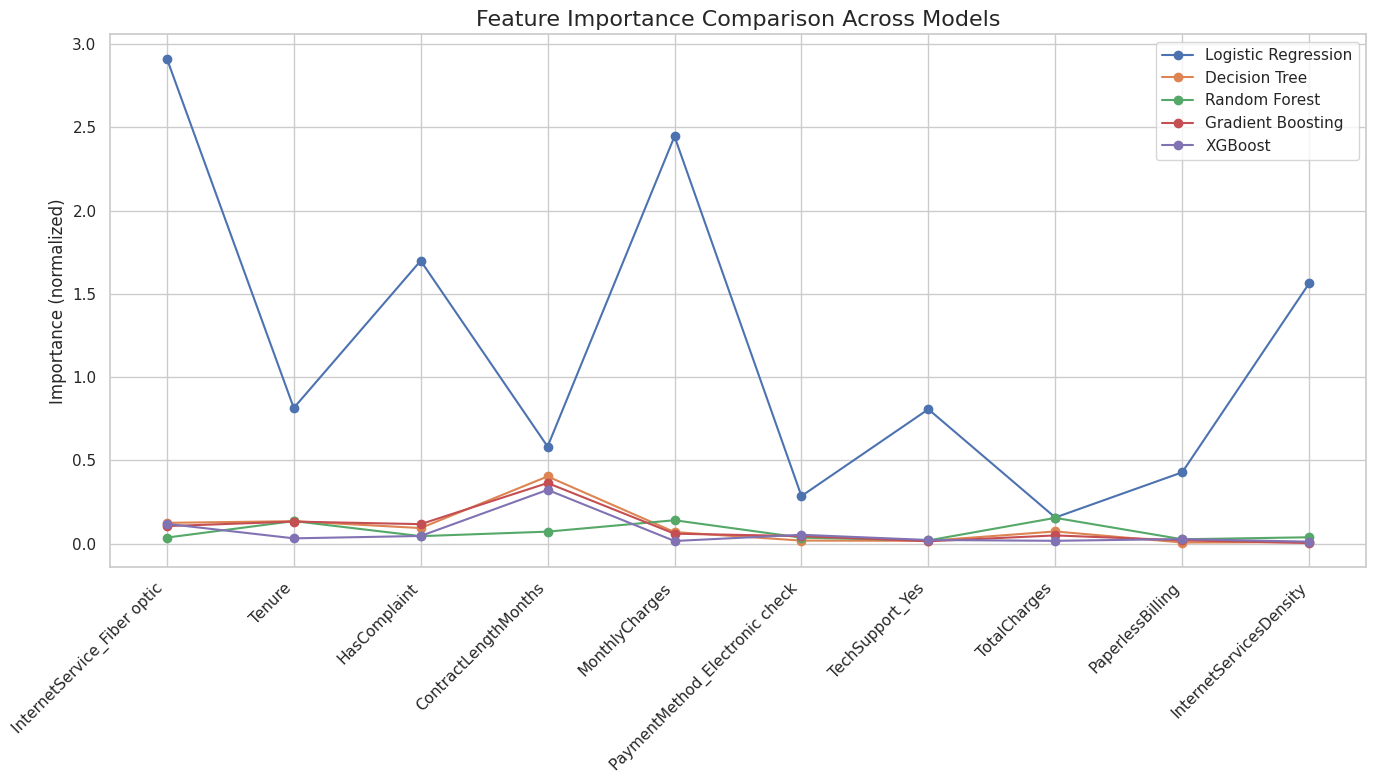

In [ ]:
print("\n===== Feature Importance Comparison =====")

# Combine feature importance from different models
importance_df = pd.DataFrame({'Feature': X_train.columns})

# Add importance from each model
if logreg_l1.coef_ is not None:
    importance_df['Logistic Regression'] = np.abs(logreg_l1.coef_[0])
importance_df['Decision Tree'] = dt_model.feature_importances_
importance_df['Random Forest'] = rf_model.feature_importances_
importance_df['Gradient Boosting'] = gb_model.feature_importances_
importance_df['XGBoost'] = xgb_model.feature_importances_

# Create a rank column for each model
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost']
for model in models:
    importance_df[f'{model} Rank'] = importance_df[model].rank(ascending=False)

# Calculate average rank and sort
importance_df['Average Rank'] = importance_df[[f'{model} Rank' for model in models]].mean(axis=1)
importance_df = importance_df.sort_values('Average Rank')

# Display top 15 features by average rank
print("\nTop 15 features by average importance rank across models:")
print(importance_df[['Feature', 'Average Rank'] + models].head(15))

# Plot top 10 features by average rank
top10_features = importance_df.head(10)['Feature'].tolist()
top10_importance = importance_df[importance_df['Feature'].isin(top10_features)]

plt.figure(figsize=(14, 8))
for model in models:
    plt.plot(top10_importance['Feature'], top10_importance[model], 'o-', label=model)
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importance Comparison Across Models', fontsize=16)
plt.ylabel('Importance (normalized)')
plt.legend()
plt.tight_layout()
plt.show()


## 6.2 Partial Dependence Plots for Key Features


===== Partial Dependence Plots (Manual Calculation) =====


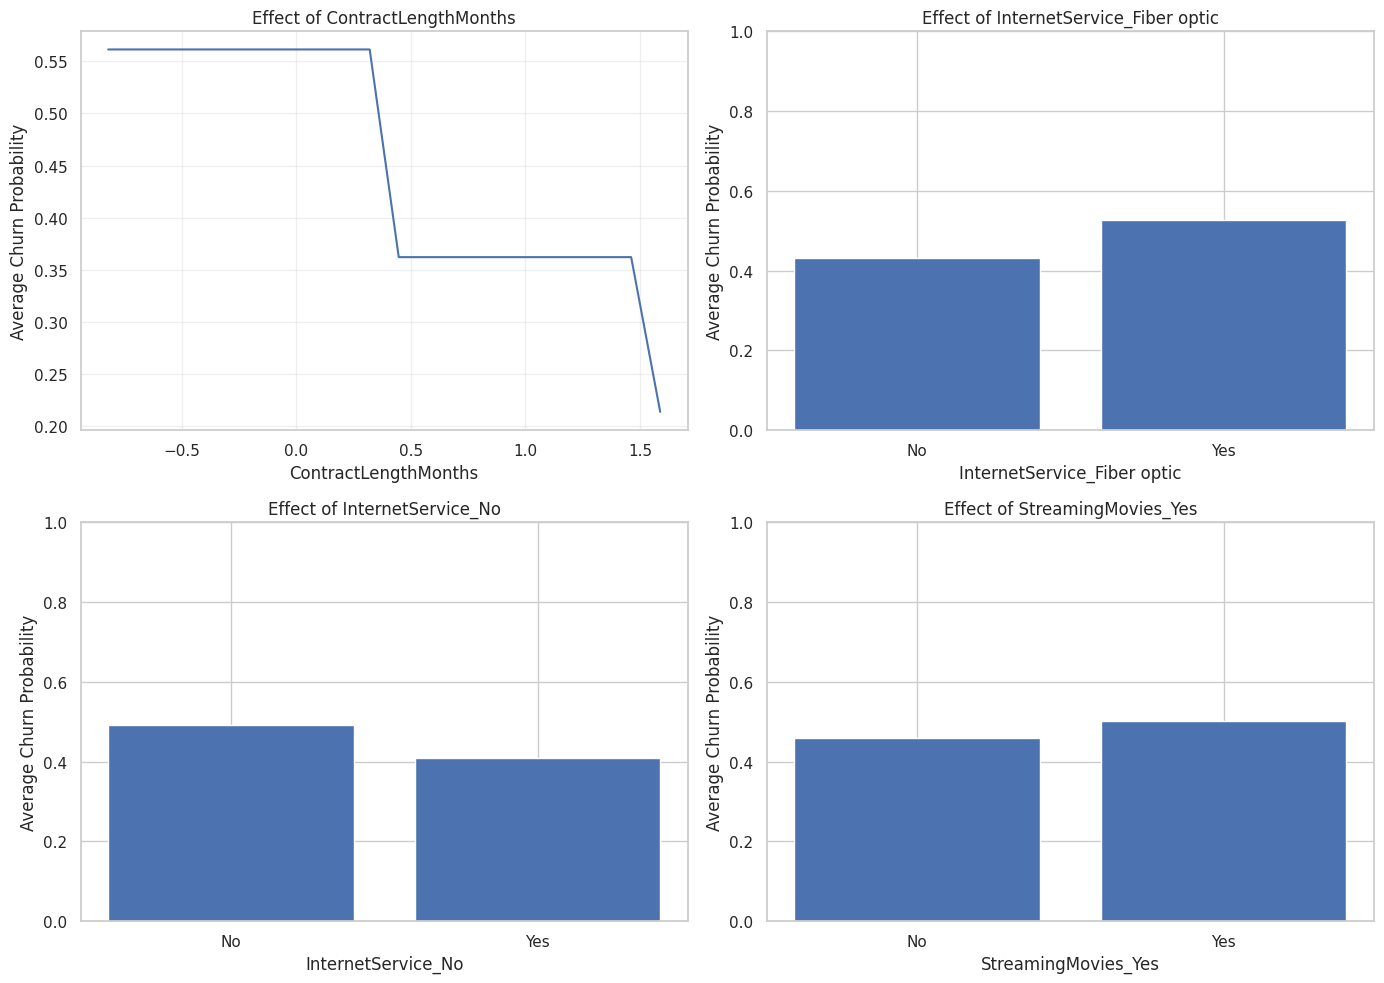

In [ ]:
# Alternative approach to partial dependence plots
print("\n===== Partial Dependence Plots (Manual Calculation) =====")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, feature in enumerate(top_features):
    # For binary features
    if feature in ['InternetService_Fiber optic', 'InternetService_No', 'StreamingMovies_Yes']:
        # Create copies of data with feature set to 0 and 1
        X_temp_0 = X_train.copy()
        X_temp_1 = X_train.copy()

        X_temp_0[feature] = 0
        X_temp_1[feature] = 1

        # Calculate average predictions for each case
        avg_pred_0 = xgb_model.predict_proba(X_temp_0)[:, 1].mean()
        avg_pred_1 = xgb_model.predict_proba(X_temp_1)[:, 1].mean()

        # Plot
        ax = axes[i]
        ax.bar(["No", "Yes"], [avg_pred_0, avg_pred_1])
        ax.set_ylim(0, 1)
        ax.set_xlabel(feature)
        ax.set_ylabel('Average Churn Probability')
        ax.set_title(f'Effect of {feature}')

    else:  # For continuous features like ContractLengthMonths
        # Define a range of values to evaluate
        min_val = X_train[feature].min()
        max_val = X_train[feature].max()
        feature_values = np.linspace(min_val, max_val, 20)

        # Calculate average prediction for each feature value
        avg_preds = []
        for val in feature_values:
            X_temp = X_train.copy()
            X_temp[feature] = val
            avg_pred = xgb_model.predict_proba(X_temp)[:, 1].mean()
            avg_preds.append(avg_pred)

        # Plot
        ax = axes[i]
        ax.plot(feature_values, avg_preds)
        ax.set_xlabel(feature)
        ax.set_ylabel('Average Churn Probability')
        ax.set_title(f'Effect of {feature}')
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6.3 SHAP Values for Model Explainability


===== SHAP Value Analysis =====


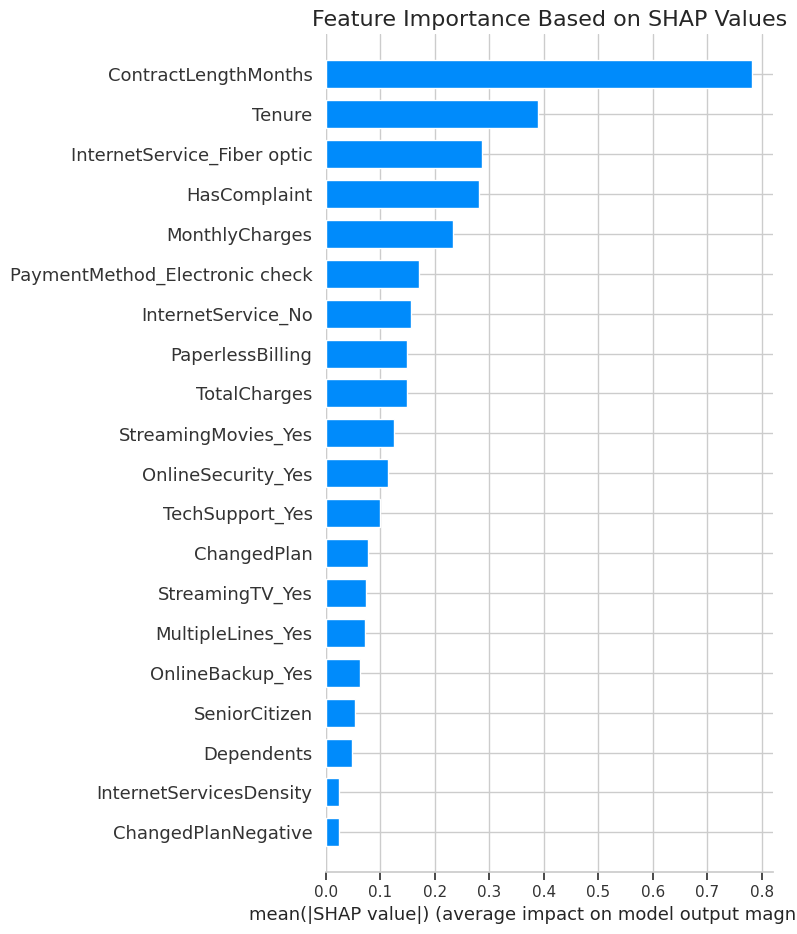

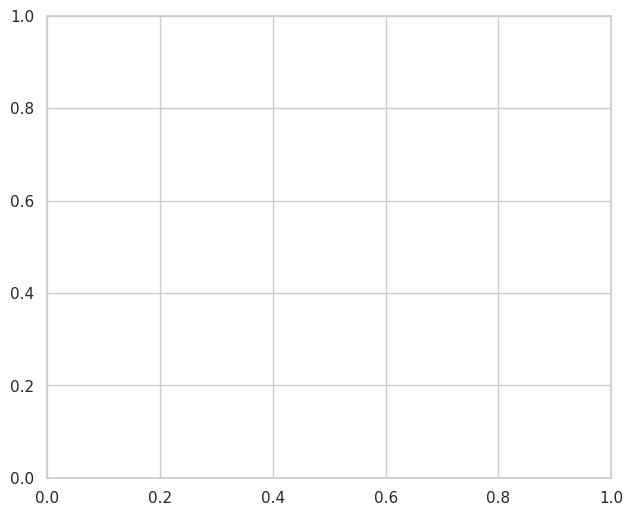

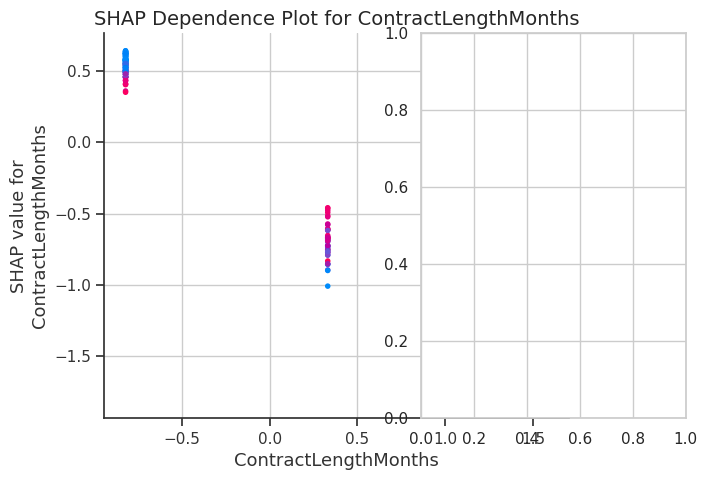

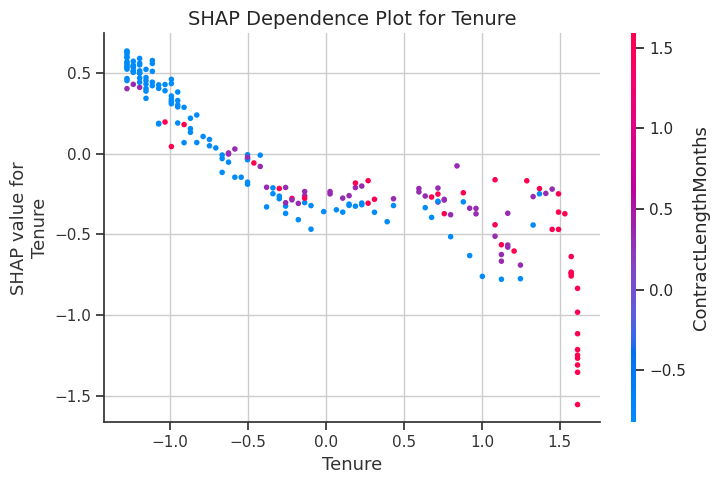

In [ ]:
print("\n===== SHAP Value Analysis =====")

# Initialize SHAP explainer with the XGBoost model
explainer = shap.Explainer(xgb_model)

# Calculate SHAP values for test set (sample for speed)
sample_size = min(200, len(X_test))
X_test_sample = X_test.sample(sample_size, random_state=42)
shap_values = explainer(X_test_sample)

# Summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False)
plt.title('Feature Importance Based on SHAP Values', fontsize=16)
plt.tight_layout()
plt.show()

# SHAP dependency plots for top 2 features
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
top_feature_idx = np.argmax(np.abs(shap_values.values).mean(0))
top_feature = X_test.columns[top_feature_idx]
shap.dependence_plot(top_feature, shap_values.values, X_test_sample, show=False)
plt.title(f'SHAP Dependence Plot for {top_feature}', fontsize=14)

plt.subplot(1, 2, 2)
second_feature_idx = np.argsort(np.abs(shap_values.values).mean(0))[-2]
second_feature = X_test.columns[second_feature_idx]
shap.dependence_plot(second_feature, shap_values.values, X_test_sample, show=False)
plt.title(f'SHAP Dependence Plot for {second_feature}', fontsize=14)

plt.tight_layout()
plt.show()